In [1]:
# File Management
import os

######################################### API Calls ###############################################
import requests # to make TMDB API calls
import locale # to format currency as USD
locale.setlocale( locale.LC_ALL, '' )

######################## Data Analysis and Machine Learning #######################################
import numpy as np
import pandas as pd

# Plotting Libraries
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
# Either manually create a folder called "plots" or run this code
if "plots" not in os.listdir(): # If folder called "plots" doesnt exist in current directory. listdir = list directory
    os.mkdir("plots") # Make a folder called "plots". mkdir = make directory

<h1>Interesting Problem</h1>
<h3>Is your movie going to be successful?</h3>

<p>There are many factors that can create a good movie</p>. 
<br>
<div>
    We will be looking at these 3 common assumptions
    <ol>
        <li>Certain genres bring about higher success rate</li> 
        <li>Popular cast usually mean that movies are more successful</li>
        <li>Higher budget would equate to higher success</li>
    </ol>
    In this project, we will assume that only these 3 factors would have a major effect on the <i>success</i> of a movie
    <br>
    <br>
    These factors would be then be compared against a <b><u>Success</u></b> which would include either
    <ul>
        <li>Revenue</li>
        <li>Vote Average</li>
    </ul>
</div>


--- 
<br>

<h1><font color=Blue>1. Data Extraction and Cleaning</font></h1>
<ol>
    <b>Steps taken</b>
    <li><b>get_year_detail</b> calls <b>get_page_detail</b> to retrieve 10 pages of top movies of a year(by revenue/vote)</li>
    <li><b>get_page_detail</b> uses API to retrieve top movies of a certain page</li>
    <li>Using list of movie names from <b>page details</b>, get individual movie details using <b>get_movie_detail</b></li>
    <li>Concat all info into 1 dataframe <b>(movie_data)</b></li>
    <li>Remove all movies that have no budget or casts</li>
</ol>

[API Documentation Site](https://developers.themoviedb.org/3/authentication/how-do-i-generate-a-session-id)</p>

### Functions Required for data collection

In [4]:
def get_movie_detail(ID,api_key):
    # Getting Movie Details
    movie = requests.get(f'https://api.themoviedb.org/3/movie/{ID}?api_key={api_key}&language=en-US')
    movie = movie.json()
    
    # Getting Cast Names
    casts = requests.get(f'https://api.themoviedb.org/3/movie/{ID}/credits?api_key={api_key}&language=en-US').json()['cast']
    casts = list(cast['name'] for cast in casts if cast['popularity']>10) #Getting list of cast names with popularity rating more than 10 (Filter less popular casts)
    
    # Dictionary to store all details
    movie_dict = {}
    movie_dict['Name of Movie'] = movie['original_title']
    movie_dict['Genres'] = list(genre['name'] for genre in movie['genres']) # to get movie IDs for each page
    movie_dict['Budget'] = movie['budget']
    movie_dict['Casts'] = casts
    movie_dict['Vote Count'] = movie['vote_count']
    movie_dict['Vote Average'] = movie['vote_average']
    movie_dict['Revenue'] = movie['revenue']
    
    return movie_dict

def get_page_detail(year,api_key,page,sort_factor):
    '''
        year : integer e.g. 2000
        api_key : string
        page : integer e.g. 10
        sort_factor : string either 'revenue' or 'vote_average'
    '''
    response = requests.get(f'https://api.themoviedb.org/3/discover/movie?api_key={api_key}&primary_release_year={year}&sort_by={sort_factor}.desc&page={page}')
    page_details = response.json()['results'] #response.json returns a dictionary {'page': 1, 'results' : ....}
    ID_list = list(x['id'] for x in page_details) # to get movie IDs for each page
    
    page_movies_list = []
    for ID in ID_list:
        page_movies_list.append(get_movie_detail(ID, api_key))
        
    
    return page_movies_list

In [5]:
def get_year_detail(year,api_key, sort_factor, total_page_num=10):
    '''
        year : integer e.g. 2000
        api_key : string
        generation : string e.g. 'x'
        sort_factor : string either 'revenue' or 'vote_average'
    '''
    year_list = []
    
    # Compiling page detail into the year_list
    for page in range(1,total_page_num+1):
        year_list.append(pd.DataFrame(get_page_detail(year,api_key,page,sort_factor)))
    
    year_detail = pd.concat(year_list).reset_index(drop=True)
    year_detail.drop(list(year_detail[year_detail['Budget']==0].index), inplace=True) # Removing rows with no budget
    year_detail.drop(list(year_detail[year_detail['Casts'].map(len)==0].index), inplace=True) # Removing rows with no casts info
    
    return year_detail

<h2>Data Cleaning</h2>
<div>
    <blockquote>year_detail['Budget']==0</blockquote>
    check for rows with budgets = 0
    <blockquote>year_detail['Casts'].map(len)==0</blockquote>
    check for rows with no casts
</div>
<br>
<p>
    year_detail.drop(list(year_detail[year_detail['Budget']==0].index), inplace=True) # Removing rows with no budget<br>
    year_detail.drop(list(year_detail[year_detail['Casts'].map(len)==0].index), inplace=True) # Removing rows with no casts info
</p>

---
<br>


### Revenue vs Vote Average as a measure for good movie

In [6]:
# Sort by revenue
get_year_detail(2000,api_key, 'revenue')

,Name of Movie,Genres,Budget,Casts,Vote Count,Vote Average,Revenue
0,Mission: Impossible II,"[Adventure, Action, Thriller]",125000000,"[Tom Cruise, Dougray Scott, Thandiwe Newton, V...",5519,6.108,546388105
1,Gladiator,"[Action, Drama, Adventure]",103000000,"[Russell Crowe, Joaquin Phoenix, Connie Nielse...",15703,8.203,465361176
2,Cast Away,"[Adventure, Drama]",90000000,"[Tom Hanks, Helen Hunt, Nick Searcy, Timothy S...",9763,7.657,429632142
3,What Women Want,"[Comedy, Romance]",70000000,"[Mel Gibson, Helen Hunt, Marisa Tomei, Alan Al...",3354,6.409,374111707
4,Dinosaur,"[Family, Animation]",127500000,"[D.B. Sweeney, Alfre Woodard, Hayden Panettier...",2114,6.496,354248063
...,...,...,...,...,...,...,...
185,உன்னை கொடு என்னை தருவேன்,"[Crime, Romance]",500000,[R. Parthiban],2,5.000,500000
193,Waking the Dead,"[Mystery, Drama, Romance]",8500000,"[Billy Crudup, Jennifer Connelly, Hal Holbrook...",73,6.200,327418
197,Love's Labour's Lost,"[Comedy, Music, Romance]",13000000,"[Kenneth Branagh, Alessandro Nivola, Matthew L...",53,5.500,299792
198,Psycho Beach Party,"[Comedy, Horror]",1500000,"[Lauren Ambrose, Thomas Gibson, Beth Broderick...",67,5.813,268117


In [7]:
# Sort by vote average
get_year_detail(2000,api_key, 'vote_average')

,Name of Movie,Genres,Budget,Casts,Vote Count,Vote Average,Revenue
18,Offending Angels,[Romance],88608,"[Susannah Harker, Andrew Lincoln, Jack Davenport]",2,10.000,100
37,Scandalize My Name: Stories from the Blacklist,[Documentary],1000000,[Morgan Freeman],1,10.000,100000
179,Gladiator,"[Action, Drama, Adventure]",103000000,"[Russell Crowe, Joaquin Phoenix, Connie Nielse...",15703,8.203,465361176
181,Memento,"[Mystery, Thriller]",9000000,"[Guy Pearce, Carrie-Anne Moss, Joe Pantoliano,...",12712,8.194,39723096
188,花樣年華,"[Drama, Romance]",150000,[Tony Leung Chiu-wai],2017,8.113,12854953
191,Requiem for a Dream,"[Crime, Drama]",4500000,"[Ellen Burstyn, Jared Leto, Jennifer Connelly,...",8419,8.034,7390108


<p>From the tables above, it is clear that <b>Revenue</b> is a <u>better measure</u> than <b>Vote Average</b> as a lot of the highly voted films has little to no information with very little vote count therefore are <b>not reliable</b> as datasets</p>

---

<br>

## Getting Dataframe of movie details
Do **NOT** run the bottom line of code if csv is already in the folder(Code takes 1hr+ to complete)

After confirming that **Revenue** is a better measure of a popular/good movie than **Vote Average**, we can continue analysing whole dataset
- 10 pages a year
- year range from 1981 to 2022
- removes outliers

Saves everything in csv file

In [223]:
# Getting Dataframe of 10 pages of movie from 1981 to 2022

data_list = []
for year in range(1981,2023):
    print(year)
    data_list.append(get_year_detail(year,api_key, 'revenue', gen))

movie_data = pd.concat(data_list)
del data_list #delete data list to free space

X 1981
X 1982
X 1983
X 1984
X 1985
X 1986
X 1987
X 1988
X 1989
X 1990
X 1991
X 1992
X 1993
X 1994
X 1995
X 1996
Y 1997
Y 1998
Y 1999
Y 2000
Y 2001
Y 2002
Y 2003
Y 2004
Y 2005
Y 2006
Y 2007
Y 2008
Y 2009
Y 2010
Y 2011
Y 2012
Z 2013
Z 2014
Z 2015
Z 2016
Z 2017
Z 2018
Z 2019
Z 2020
Z 2021
Z 2022


In [224]:
movie_data.to_csv("tmdb_topRevenueData.csv") # Saving to csv

---

<br>

<h1><font color=Blue>2. Data Visualisation</font></h1>

### Continuing from csv instead of reading API
if there is a csv file already made from the data, skip step 1 (**Data Extraction and Cleaning**) and go straight to this code

In [8]:
movie_data = pd.read_csv("tmdb_topRevenueData.csv", index_col = 'Unnamed: 0').reset_index(drop=True)
movie_data

,Name of Movie,Genres,Budget,Casts,Vote Count,Vote Average,Revenue,Gen
0,Raiders of the Lost Ark,"['Adventure', 'Action']",18000000,"['Harrison Ford', 'Karen Allen', 'Paul Freeman...",10400,7.922,389925971,X
1,For Your Eyes Only,"['Adventure', 'Action', 'Thriller']",28000000,"['Roger Moore', 'Carole Bouquet', 'Lynn-Holly ...",1478,6.477,195312802,X
2,Porky's,['Comedy'],4000000,['Kim Cattrall'],690,6.419,125728258,X
3,On Golden Pond,"['Adventure', 'Drama', 'Romance']",15000000,"['Henry Fonda', 'Jane Fonda', 'Dabney Coleman']",359,7.333,119285432,X
4,Arthur,"['Comedy', 'Drama', 'Romance']",7000000,"['Paul Gleason', 'Mark Margolis']",335,6.530,95461682,X
...,...,...,...,...,...,...,...,...
5354,Infinite Storm,"['Drama', 'Thriller']",4749917,"['Naomi Watts', ""Denis O'Hare""]",90,6.206,1564696,Z
5355,Les passagers de la nuit,['Drama'],4300000,"['Charlotte Gainsbourg', 'Emmanuelle Béart']",44,7.023,1396831,Z
5356,Terrifier 2,"['Horror', 'Thriller']",250000,"['Lauren LaVera', 'David Howard Thornton', 'Gr...",5,7.000,1200000,Z
5357,Gold,"['Thriller', 'Action']",6500000,['Zac Efron'],393,6.295,176048,Z


<br>

### Measure of a good movie
- As a measure of good movie, we will be seeing how much profit was made with reference to budget
- For profit, equation would be : `profit = Revenue - Budget`
- For success, equation would be : `Success = profit/budget`

In [9]:
movie_data['Profit'] = movie_data['Revenue'] - movie_data['Budget']
movie_data['Success'] = round(movie_data['Profit']/movie_data['Budget'],4) # Round it to 4 dec place for easier visualisation
movie_data

,Name of Movie,Genres,Budget,Casts,Vote Count,Vote Average,Revenue,Gen,Profit,Success
0,Raiders of the Lost Ark,"['Adventure', 'Action']",18000000,"['Harrison Ford', 'Karen Allen', 'Paul Freeman...",10400,7.922,389925971,X,371925971,20.6626
1,For Your Eyes Only,"['Adventure', 'Action', 'Thriller']",28000000,"['Roger Moore', 'Carole Bouquet', 'Lynn-Holly ...",1478,6.477,195312802,X,167312802,5.9755
2,Porky's,['Comedy'],4000000,['Kim Cattrall'],690,6.419,125728258,X,121728258,30.4321
3,On Golden Pond,"['Adventure', 'Drama', 'Romance']",15000000,"['Henry Fonda', 'Jane Fonda', 'Dabney Coleman']",359,7.333,119285432,X,104285432,6.9524
4,Arthur,"['Comedy', 'Drama', 'Romance']",7000000,"['Paul Gleason', 'Mark Margolis']",335,6.530,95461682,X,88461682,12.6374
...,...,...,...,...,...,...,...,...,...,...
5354,Infinite Storm,"['Drama', 'Thriller']",4749917,"['Naomi Watts', ""Denis O'Hare""]",90,6.206,1564696,Z,-3185221,-0.6706
5355,Les passagers de la nuit,['Drama'],4300000,"['Charlotte Gainsbourg', 'Emmanuelle Béart']",44,7.023,1396831,Z,-2903169,-0.6752
5356,Terrifier 2,"['Horror', 'Thriller']",250000,"['Lauren LaVera', 'David Howard Thornton', 'Gr...",5,7.000,1200000,Z,950000,3.8000
5357,Gold,"['Thriller', 'Action']",6500000,['Zac Efron'],393,6.295,176048,Z,-6323952,-0.9729


<br>

### Visualising Success
Seeing the distribution of Success from all movies

In [10]:
success_df = pd.DataFrame(movie_data['Success'])
success_df.describe() # Written Description of success

,Success
count,5.359000e+03
mean,4.922176e+02
std,2.552029e+04
min,-9.986000e-01
25%,7.700000e-03
50%,1.190000e+00
75%,3.136950e+00
max,1.545929e+06


<AxesSubplot:>

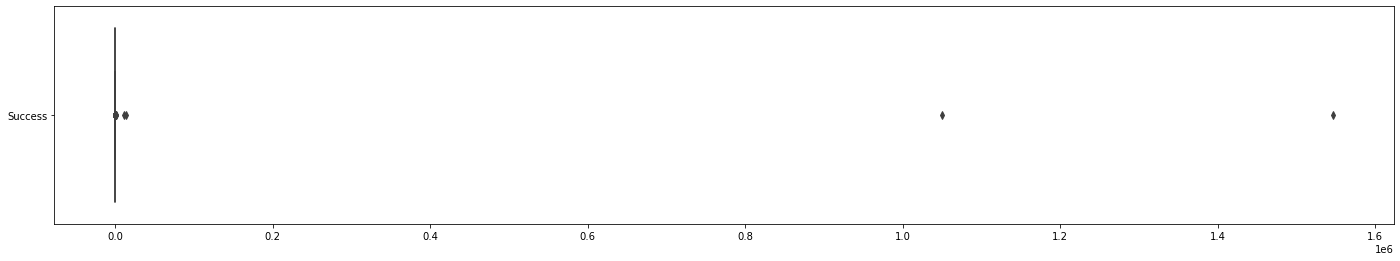

In [11]:
f = plt.figure(figsize=(24, 4))
sb.boxplot(data = success_df, orient = "h")

From this boxplot, some outliers can be identified(values that are >10) and removed for better visualisation

<br>

<h5>Cleaning Data</h5>
Inspecting `Budget` further as there could be the contributing factor to these outliers

In [12]:
movie_data['Budget'].describe()

count    5.359000e+03
mean     3.820260e+07
std      4.428827e+07
min      7.000000e+00
25%      1.000000e+07
50%      2.300000e+07
75%      5.000000e+07
max      5.000000e+08
Name: Budget, dtype: float64

From the description, it can be seen that the minimum budget is $7 however, this is not feasible. Hence, we would be filtering out any movies with `Budget` < 100,000

In [13]:
movie_data.drop(movie_data.loc[movie_data['Budget']<100_000].index, inplace=True) # Dropping rows where budget < 100,000
movie_data.reset_index(drop=True,inplace=True) # Reset Index

In [14]:
movie_data

,Name of Movie,Genres,Budget,Casts,Vote Count,Vote Average,Revenue,Gen,Profit,Success
0,Raiders of the Lost Ark,"['Adventure', 'Action']",18000000,"['Harrison Ford', 'Karen Allen', 'Paul Freeman...",10400,7.922,389925971,X,371925971,20.6626
1,For Your Eyes Only,"['Adventure', 'Action', 'Thriller']",28000000,"['Roger Moore', 'Carole Bouquet', 'Lynn-Holly ...",1478,6.477,195312802,X,167312802,5.9755
2,Porky's,['Comedy'],4000000,['Kim Cattrall'],690,6.419,125728258,X,121728258,30.4321
3,On Golden Pond,"['Adventure', 'Drama', 'Romance']",15000000,"['Henry Fonda', 'Jane Fonda', 'Dabney Coleman']",359,7.333,119285432,X,104285432,6.9524
4,Arthur,"['Comedy', 'Drama', 'Romance']",7000000,"['Paul Gleason', 'Mark Margolis']",335,6.530,95461682,X,88461682,12.6374
...,...,...,...,...,...,...,...,...,...,...
5335,The King's Daughter,"['Fantasy', 'Drama', 'Romance', 'History']",40500000,"['Pierce Brosnan', 'Kaya Scodelario', 'Benjami...",574,7.251,2182492,Z,-38317508,-0.9461
5336,Infinite Storm,"['Drama', 'Thriller']",4749917,"['Naomi Watts', ""Denis O'Hare""]",90,6.206,1564696,Z,-3185221,-0.6706
5337,Les passagers de la nuit,['Drama'],4300000,"['Charlotte Gainsbourg', 'Emmanuelle Béart']",44,7.023,1396831,Z,-2903169,-0.6752
5338,Terrifier 2,"['Horror', 'Thriller']",250000,"['Lauren LaVera', 'David Howard Thornton', 'Gr...",5,7.000,1200000,Z,950000,3.8000


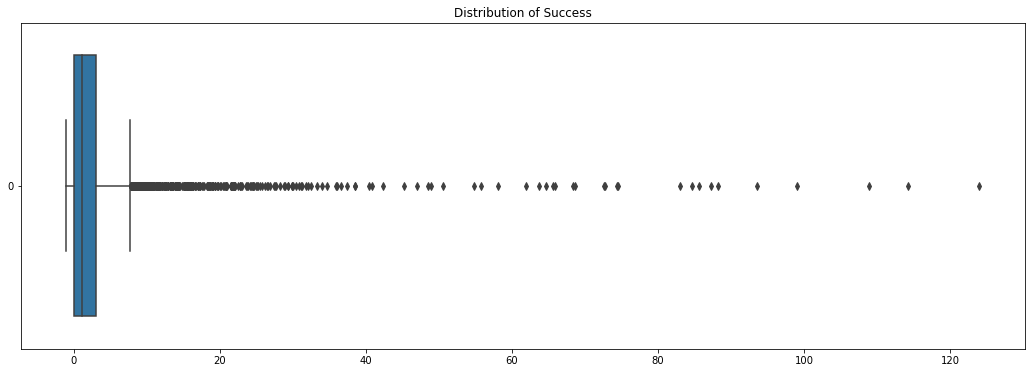

In [21]:
# Plotting
f = plt.figure(figsize=(18, 6))
plt.title("Distribution of Success")
sb.boxplot(data = movie_data['Success'], orient = "h")
plt.savefig("plots/success_boxplot.png") #Save plot

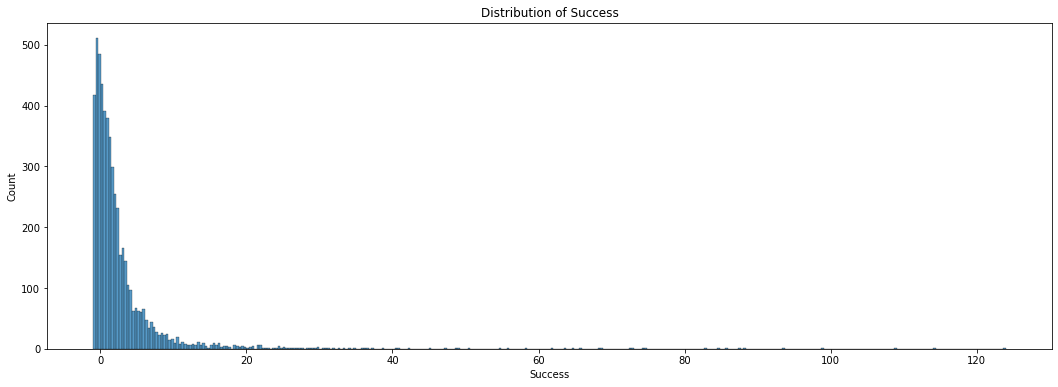

In [22]:
# Plotting
f = plt.figure(figsize=(18,6))
plt.title("Distribution of Success")
sb.histplot(data = movie_data['Success'])
plt.savefig("plots/success_histplot.png") #Save plot

From these plots, we have decided that a movie with **"Success" > 1** would be considered a **good movie**, else it is considered a bad movie. Hence now an edit will be done to the main dataframe to reflect this decision.

In [11]:
success_threshold = 1

# Editing Movie Dataframe such that "Success > success_threshold" would be counted as successful 
movie_data['Successful'] = True # Creating a new column by setting everything to True
movie_data.loc[movie_data['Success'] < success_threshold,'Successful'] = False # Setting rows with Success <2 to False
movie_data

,Name of Movie,Genres,Budget,Casts,Vote Count,Vote Average,Revenue,Gen,Profit,Success,Successful
0,Raiders of the Lost Ark,"['Adventure', 'Action']",18000000,"['Harrison Ford', 'Karen Allen', 'Paul Freeman...",10400,7.922,389925971,X,371925971,20.6626,True
1,For Your Eyes Only,"['Adventure', 'Action', 'Thriller']",28000000,"['Roger Moore', 'Carole Bouquet', 'Lynn-Holly ...",1478,6.477,195312802,X,167312802,5.9755,True
2,Porky's,['Comedy'],4000000,['Kim Cattrall'],690,6.419,125728258,X,121728258,30.4321,True
3,On Golden Pond,"['Adventure', 'Drama', 'Romance']",15000000,"['Henry Fonda', 'Jane Fonda', 'Dabney Coleman']",359,7.333,119285432,X,104285432,6.9524,True
4,Arthur,"['Comedy', 'Drama', 'Romance']",7000000,"['Paul Gleason', 'Mark Margolis']",335,6.530,95461682,X,88461682,12.6374,True
...,...,...,...,...,...,...,...,...,...,...,...
5335,The King's Daughter,"['Fantasy', 'Drama', 'Romance', 'History']",40500000,"['Pierce Brosnan', 'Kaya Scodelario', 'Benjami...",574,7.251,2182492,Z,-38317508,-0.9461,False
5336,Infinite Storm,"['Drama', 'Thriller']",4749917,"['Naomi Watts', ""Denis O'Hare""]",90,6.206,1564696,Z,-3185221,-0.6706,False
5337,Les passagers de la nuit,['Drama'],4300000,"['Charlotte Gainsbourg', 'Emmanuelle Béart']",44,7.023,1396831,Z,-2903169,-0.6752,False
5338,Terrifier 2,"['Horror', 'Thriller']",250000,"['Lauren LaVera', 'David Howard Thornton', 'Gr...",5,7.000,1200000,Z,950000,3.8000,True


In [12]:
movie_data['Successful'].value_counts()

True     2874
False    2466
Name: Successful, dtype: int64

<Figure size 2160x1152 with 0 Axes>

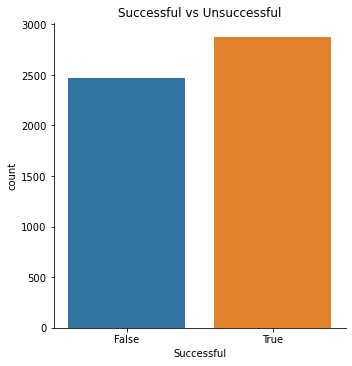

In [13]:
# Plotting
f = plt.figure(figsize=(30, 16))
sb.catplot(x = 'Successful',data = pd.DataFrame(movie_data['Successful']), kind = "count", orient ="h")
plt.title("Successful vs Unsuccessful")
plt.savefig("plots/SuccessvsUnsuccessful.png") #Save plot


---

<br>

### Visualising Factors
- Genres
- Casts
- Budget

### 2.1 Genres

### Function to convert string to list
- dataframe issues where list are stored as strings

In [14]:
# Issue with list in Dataframe
string_list = "['Adventure', 'Action']"

def string_to_list(str):
    lst = []
    temp_word = ""
    for char in str :
        if char == ',': # If there is a comma, append word to list
            lst.append(temp_word)
            temp_word = ''
            
        elif char in ["'", "[","]", " ", ""]: # Ignore these characters
            pass
        
        else:
            temp_word += char
            
    lst.append(temp_word) #Appending last word cos no comma
    return lst

string_to_list(string_list)

['Adventure', 'Action']

In [15]:
# Dictionary of Genres
Genre_dict ={}
for string_rows in movie_data['Genres'] :
    list_row = string_to_list(string_rows) # Issue is that the list of genres is stored as string hence need this function to convert
    for genre in list_row :
        if genre == "": # Some identify themselves as genreless
            genre = "Genreless"
        try:
            Genre_dict[genre] += 1
        except KeyError :
            Genre_dict[genre] = 1

Genre_df = pd.DataFrame(Genre_dict, index =['Count'])
Genre_df

,Adventure,Action,Thriller,Comedy,Drama,Romance,History,War,ScienceFiction,Family,Fantasy,Crime,Horror,Mystery,Music,Animation,Western,Documentary,TVMovie,Genreless
Count,1057,1541,1411,2060,2302,977,271,168,659,658,641,850,608,459,160,338,62,31,4,1


In [16]:
# Sorting Genres for easier visualisation
Genre_sorted = Genre_df.T.sort_values(by="Count",ascending=False).T
Genre_sorted

,Drama,Comedy,Action,Thriller,Adventure,Romance,Crime,ScienceFiction,Family,Fantasy,Horror,Mystery,Animation,History,War,Music,Western,Documentary,TVMovie,Genreless
Count,2302,2060,1541,1411,1057,977,850,659,658,641,608,459,338,271,168,160,62,31,4,1


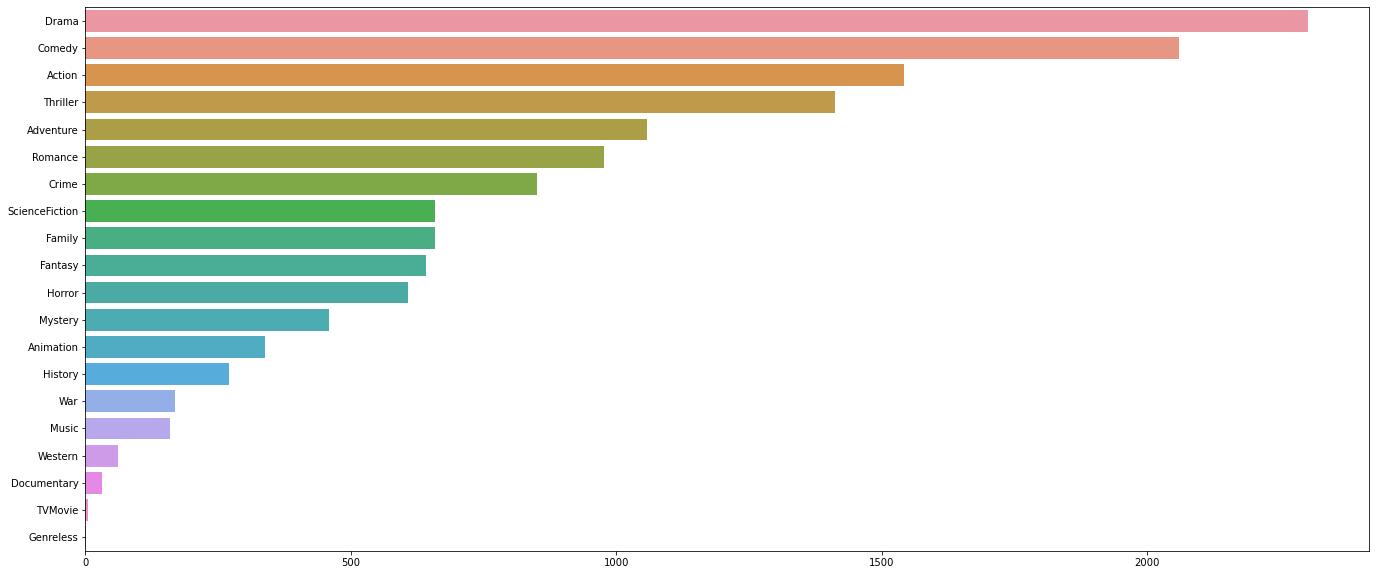

In [17]:
# Plotting
f = plt.figure(figsize=(23, 10))
sb.barplot(data = Genre_sorted, orient = "h")
plt.savefig("plots\genre_barplot.png")

From the plot, we can tell that **Drama** and **Comedy** are the most popular genres while **TV Movies** and **Genre-less** are least popular genres

<br>

### Finding the Success distribution for both Drama and Comedy movies

In [18]:
# Popular Genres analysis ("Drama and Comedy")
popular_list = []
for i,string_rows in enumerate(movie_data['Genres']) :
    list_row = string_to_list(string_rows) # Issue is that the list of genres is stored as string hence need this function to convert
    for genre in list_row :
        if genre == "Drama" or genre == 'Comedy':
            popular_list.append(movie_data[i:i+1])

popular_df = pd.concat(popular_list).reset_index(drop = True)
popular_success = pd.DataFrame(popular_df["Successful"])
popular_df["Successful"].value_counts()

True     2287
False    2075
Name: Successful, dtype: int64

<Figure size 2160x1152 with 0 Axes>

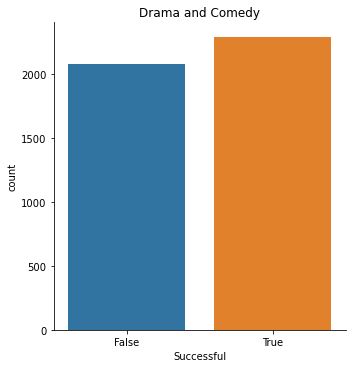

In [19]:
# Plotting
f = plt.figure(figsize=(30, 16))
sb.catplot(x = 'Successful',data = popular_success, kind = "count", orient ="h")
plt.title("Drama and Comedy")
plt.savefig("plots/popular_genre_success.png") #Save plot

From the plots we can determine that Success of Drama and Comedy genres is not directly correlated as Success is equally distributed

<br>

### Finding the Success distribution for both TVMovie and Genreless movies

In [20]:
# Popular Genres analysis ("Drama and Comedy")
notpopular_list = []
for i,string_rows in enumerate(movie_data['Genres']) :
    list_row = string_to_list(string_rows) # Issue is that the list of genres is stored as string hence need this function to convert
    for genre in list_row :
        if genre == "TVMovie" or genre == 'Genreless':
            notpopular_list.append(movie_data[i:i+1])

notpopular_df = pd.concat(notpopular_list).reset_index(drop = True)
notpopular_success = pd.DataFrame(notpopular_df["Successful"])
notpopular_df["Successful"].value_counts()

True     3
False    1
Name: Successful, dtype: int64

<Figure size 2160x1152 with 0 Axes>

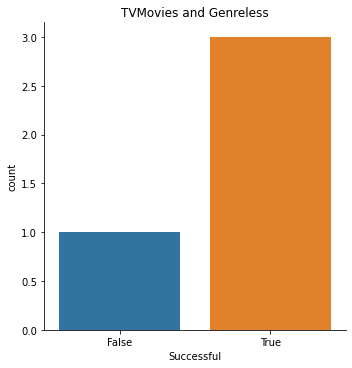

In [21]:
# Plotting
f = plt.figure(figsize=(30, 16))
sb.catplot(x = 'Successful',data = notpopular_success, kind = "count", orient ="h")
plt.title("TVMovies and Genreless")
plt.savefig("plots/unpopular_genre_success.png") #Save plot

Unpopular genres are more successful according to the plots however, there are also less movie with such genres hence these deductions are **not conclusive**

---

<br>

### 2.2 Cast
Finding the top 10 most popular cast members and the bottom 10 least popular cast members

In [22]:
cast_dict = {}

for i,string_rows in enumerate(movie_data['Casts']) :
    list_row = string_to_list(string_rows) # Issue is that the list of casts is stored as string hence need this function to convert
    for cast in list_row :
        try:
            cast_dict[cast] += 1
        except KeyError :
            cast_dict[cast] = 1

# Converting from dictionary to dataframe for easier visualistion
cast_df = pd.DataFrame(cast_dict, index = ["count"]) # Add column called count
cast_df = cast_df.T.sort_values(by="count", ascending=False) # Sort dataframe
cast_df

,count
FrankWelker,95
SamuelL.Jackson,86
BruceWillis,65
RobertDeNiro,62
LiamNeeson,61
...,...
ZlatkoBurić,1
JohnHamburg,1
JoeTurkel,1
CharlesBaker,1


<br>

**Top 100 most popular cast members**

In [23]:
cast_df[:100]

,count
FrankWelker,95
SamuelL.Jackson,86
BruceWillis,65
RobertDeNiro,62
LiamNeeson,61
...,...
JimCarrey,34
JimBroadbent,34
MichellePfeiffer,34
BrianCox,34


**Bottom 100 most popular cast members**

In [24]:
cast_df[-100:]

,count
UhmJung-hwa,1
LeeMin-ki,1
KimYou-jung,1
NinavanPallandt,1
TomLipinski,1
...,...
ZlatkoBurić,1
JohnHamburg,1
JoeTurkel,1
CharlesBaker,1


<br>

**Checking for movies that popular cast members play in** <br>
Seeing if the movies they played are successful

In [25]:
# Popular Cast analysis
popular_cast_list = []
for i,string_rows in enumerate(movie_data['Casts']) :
    list_row = string_to_list(string_rows) # Issue is that the list of casts is stored as string hence need this function to convert
    for cast in list_row :
        if cast in cast_df[:10].index: # Top 10 popular cast
            popular_cast_list.append(movie_data[i:i+1])

popular_cast_df = pd.concat(popular_cast_list).reset_index(drop = True)
popular_cast_success = pd.DataFrame(popular_cast_df["Successful"])
popular_cast_df["Successful"].value_counts()

True     350
False    290
Name: Successful, dtype: int64

<Figure size 2160x1152 with 0 Axes>

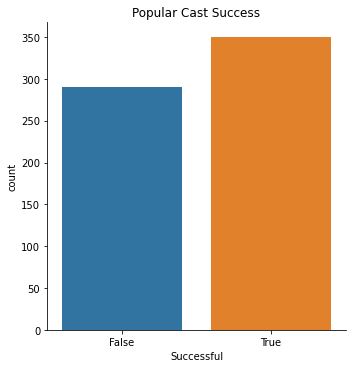

In [26]:
# Plotting
f = plt.figure(figsize=(30, 16))
sb.catplot(x = 'Successful',data = popular_cast_df, kind = "count", orient ="h")
plt.title("Popular Cast Success")
plt.savefig("plots/popular_cast_success.png") #Save plot

These results goes against conventional thought process of **popular casts brings good movies** as there are still a significant amount of "unsuccesful" movies despite having popular casts. However, there are slightly more successful movies than unsuccessful movies hence there is still some weight to this claim

<br>

In [27]:
# Popular Cast analysis
unpopular_cast_list = []
for i,string_rows in enumerate(movie_data['Casts']) :
    list_row = string_to_list(string_rows) # Issue is that the list of casts is stored as string hence need this function to convert
    for cast in list_row :
        if cast in cast_df[-10:].index: # Top 10 popular cast
            unpopular_cast_list.append(movie_data[i:i+1])

unpopular_cast_df = pd.concat(unpopular_cast_list).reset_index(drop = True)
unpopular_cast_success = pd.DataFrame(unpopular_cast_df["Successful"])
unpopular_cast_df["Successful"].value_counts()

True     8
False    2
Name: Successful, dtype: int64

<Figure size 2160x1152 with 0 Axes>

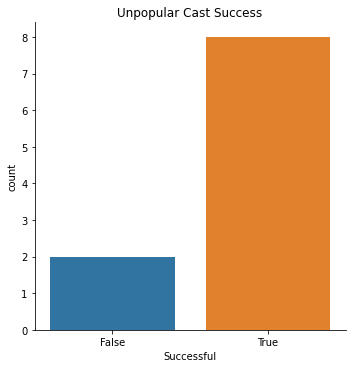

In [28]:
# Plotting
f = plt.figure(figsize=(30, 16))
sb.catplot(x = 'Successful',data = unpopular_cast_df, kind = "count", orient ="h")
plt.title("Unpopular Cast Success")
plt.savefig("plots/unpopular_cast_success.png") #Save plot

These results further **disprove** the claim that only popular cast make successful movies as there are more successful movie than unsuccessful movie with the bottom 10 most popular cast members

---

<br>

### 2.3 Budget
Analyzing the claim that a bigger budget would make a better movie

In [29]:
movie_data["Budget"].describe()

count    5.340000e+03
mean     3.833844e+07
std      4.430830e+07
min      1.000000e+05
25%      1.000000e+07
50%      2.400000e+07
75%      5.000000e+07
max      5.000000e+08
Name: Budget, dtype: float64

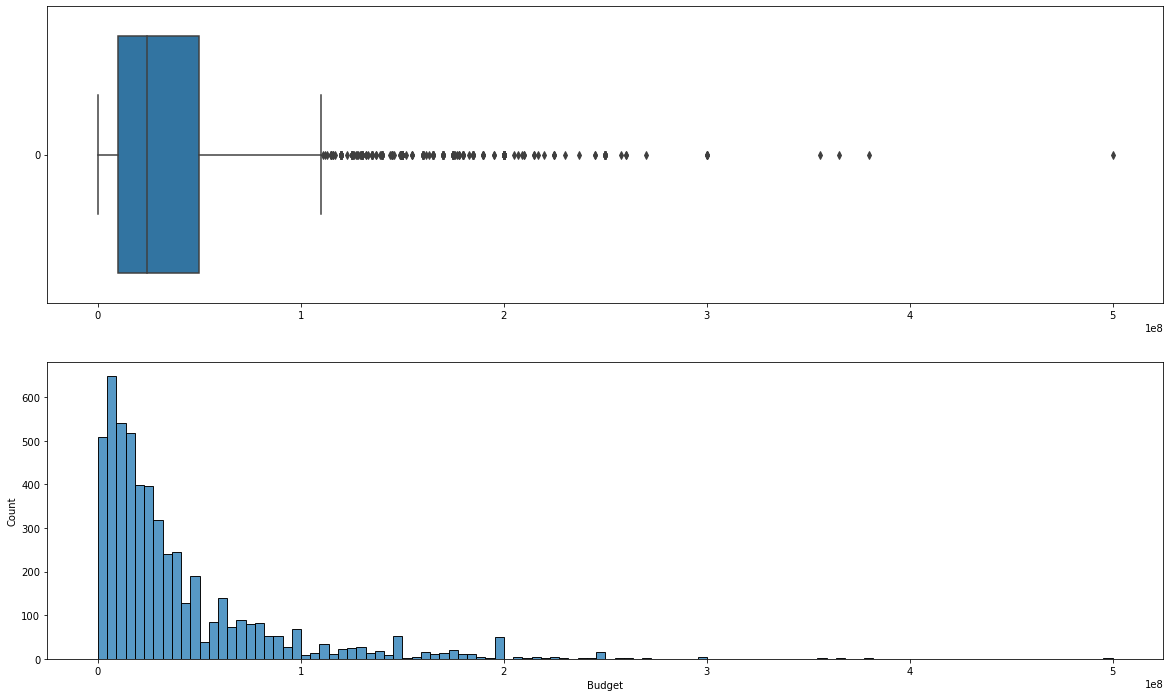

In [30]:
# Distribution of Budget
f,axes = plt.subplots(2,1,figsize=(20, 12))
sb.boxplot(data = movie_data["Budget"], orient = "h", ax=axes[0])
sb.histplot(data = movie_data["Budget"], ax=axes[1])

plt.savefig("plots/budget_distribution.png")

From the analysis of budget above, we can consider movies with a budget of **more than 100 million as high budget** as most movies within the 75 and 25 percentile only have a budget of 10 to 50 million. Those films with less than **5 million dollar with be considered as low budget.**

<br>

### High Budget Movies
Movies that have a budget of **more than USD$100 Million**

In [31]:
high_budget = movie_data.loc[movie_data['Budget'] >= 1*(10**8)]
high_budget

,Name of Movie,Genres,Budget,Casts,Vote Count,Vote Average,Revenue,Gen,Profit,Success,Successful
779,Terminator 2: Judgment Day,"['Action', 'Thriller', 'Science Fiction']",102000000,"['Arnold Schwarzenegger', 'Linda Hamilton', 'E...",10732,8.081,520000000,X,418000000,4.0980,True
1095,True Lies,"['Action', 'Thriller']",115000000,"['Arnold Schwarzenegger', 'Jamie Lee Curtis', ...",3330,7.040,378882411,X,263882411,2.2946,True
1194,Batman Forever,"['Action', 'Crime', 'Fantasy']",100000000,"['Val Kilmer', 'Tommy Lee Jones', 'Jim Carrey'...",4437,5.398,336529144,X,236529144,2.3653,True
1197,Waterworld,"['Adventure', 'Action', 'Science Fiction']",175000000,"['Kevin Costner', 'Dennis Hopper', 'Jeanne Tri...",3041,6.158,264218220,X,89218220,0.5098,False
1324,The Hunchback of Notre Dame,"['Drama', 'Animation', 'Family']",100000000,"['Tom Hulce', 'Demi Moore', 'Tony Jay', 'Kevin...",4302,7.092,325338851,X,225338851,2.2534,True
...,...,...,...,...,...,...,...,...,...,...,...
5285,Uncharted,"['Action', 'Adventure']",120000000,"['Tom Holland', 'Mark Wahlberg', 'Sophia Ali',...",3663,7.108,401748820,Z,281748820,2.3479,True
5289,Lightyear,"['Animation', 'Action', 'Adventure', 'Family',...",200000000,"['Chris Evans', 'Keke Palmer', 'Taika Waititi'...",2202,7.200,226400000,Z,26400000,0.1320,False
5308,Moonfall,['Science Fiction'],146000000,"['Halle Berry', 'Patrick Wilson', 'Charlie Plu...",1917,6.402,59100000,Z,-86900000,-0.5952,False
5321,Turning Red,"['Animation', 'Family', 'Comedy', 'Fantasy']",190000000,"['Sandra Oh', 'Maitreyi Ramakrishnan', 'James ...",3392,7.531,18879922,Z,-171120078,-0.9006,False


<Figure size 2160x1152 with 0 Axes>

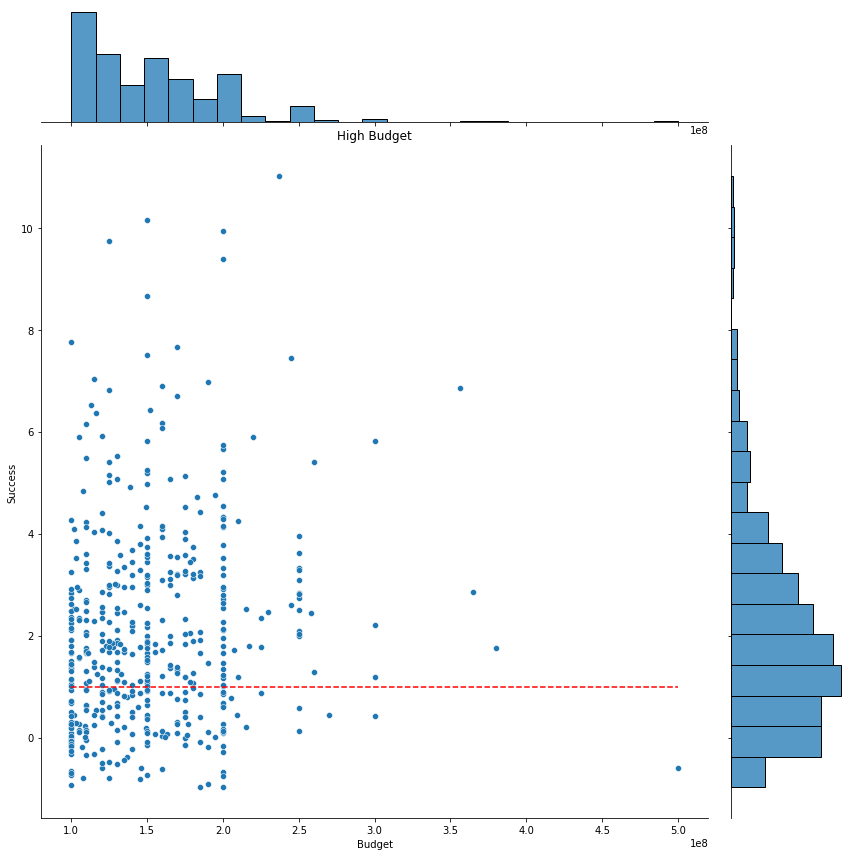

In [32]:
# Distribution of Success of High budget film
f = plt.figure(figsize=(30, 16))
sb.jointplot(data = high_budget, x = "Budget", y = "Success", height = 12)

#plt.plot([range of x], [range of y], style, color)
plt.plot([high_budget['Budget'].min(),high_budget['Budget'].max()],[1,1],'--',color='Red')

plt.title("High Budget")
plt.savefig("plots\HighBudgetvsSuccess_plot.png")

- As can be seen from the plot above, Budget and Success do not have much of a correlation as success is **evenly distributed around the 100 to 200 million dollar budget range**. 
- However, above 200 million dollars, most movie tend to be more successful with Success >= 1.

In [33]:
# Comparison of Successful vs Unsuccessful
high_budget_success = high_budget['Successful']
high_budget_success.value_counts()

True     318
False    161
Name: Successful, dtype: int64

<Figure size 2160x1152 with 0 Axes>

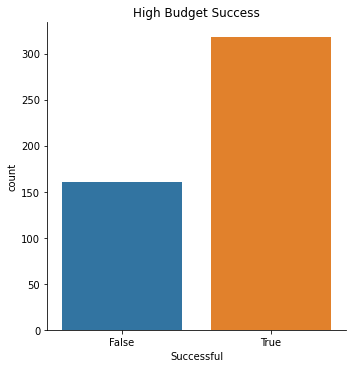

In [34]:
# Plotting
f = plt.figure(figsize=(30, 16))
sb.catplot(x = 'Successful',data = high_budget, kind = "count", orient ="h")
plt.title("High Budget Success")
plt.savefig("plots/high_budget_success.png") #Save plot

- From these analysis, it is fair to say that a higher budget **definitely has an impact on success** as there are almost <u>twice as many successful movies as there are unsuccessful movie</u> with a high budget 

<br>

### Low Budget Movies
Movies with less than $5 Million budget

In [35]:
low_budget = movie_data.loc[movie_data['Budget'] < 5*(10**6)]
low_budget

,Name of Movie,Genres,Budget,Casts,Vote Count,Vote Average,Revenue,Gen,Profit,Success,Successful
2,Porky's,['Comedy'],4000000,['Kim Cattrall'],690,6.419,125728258,X,121728258,30.4321,True
11,Hardly Working,['Comedy'],3400000,['Jerry Lewis'],18,4.500,49000000,X,45600000,13.4118,True
25,The Evil Dead,['Horror'],350000,"['Bruce Campbell', 'Ted Raimi', 'Sam Raimi']",3096,7.313,29400000,X,29050000,83.0000,True
27,Private Lessons,"['Comedy', 'Romance']",2800000,"['Sylvia Kristel', 'Howard Hesseman', 'Ed Begl...",73,5.726,26279000,X,23479000,8.3854,True
29,Halloween II,"['Horror', 'Thriller']",2500000,"['Jamie Lee Curtis', 'Donald Pleasence', 'Pame...",1594,6.550,25533818,X,23033818,9.2135,True
...,...,...,...,...,...,...,...,...,...,...,...
5319,Father Stu,['Drama'],4000000,"['Mark Wahlberg', 'Mel Gibson', 'Jacki Weaver'...",302,7.500,21591034,Z,17591034,4.3978,True
5326,Fall,['Thriller'],3000000,"['Grace Caroline Currey', 'Virginia Gardner', ...",1354,7.402,11900000,Z,8900000,2.9667,True
5336,Infinite Storm,"['Drama', 'Thriller']",4749917,"['Naomi Watts', ""Denis O'Hare""]",90,6.206,1564696,Z,-3185221,-0.6706,False
5337,Les passagers de la nuit,['Drama'],4300000,"['Charlotte Gainsbourg', 'Emmanuelle Béart']",44,7.023,1396831,Z,-2903169,-0.6752,False


In [36]:
low_budget['Success'].describe()

count    527.00000
mean       9.45578
std       17.26949
min       -0.99170
25%        0.73215
50%        3.54940
75%        9.63355
max      124.00280
Name: Success, dtype: float64

<Figure size 2160x1152 with 0 Axes>

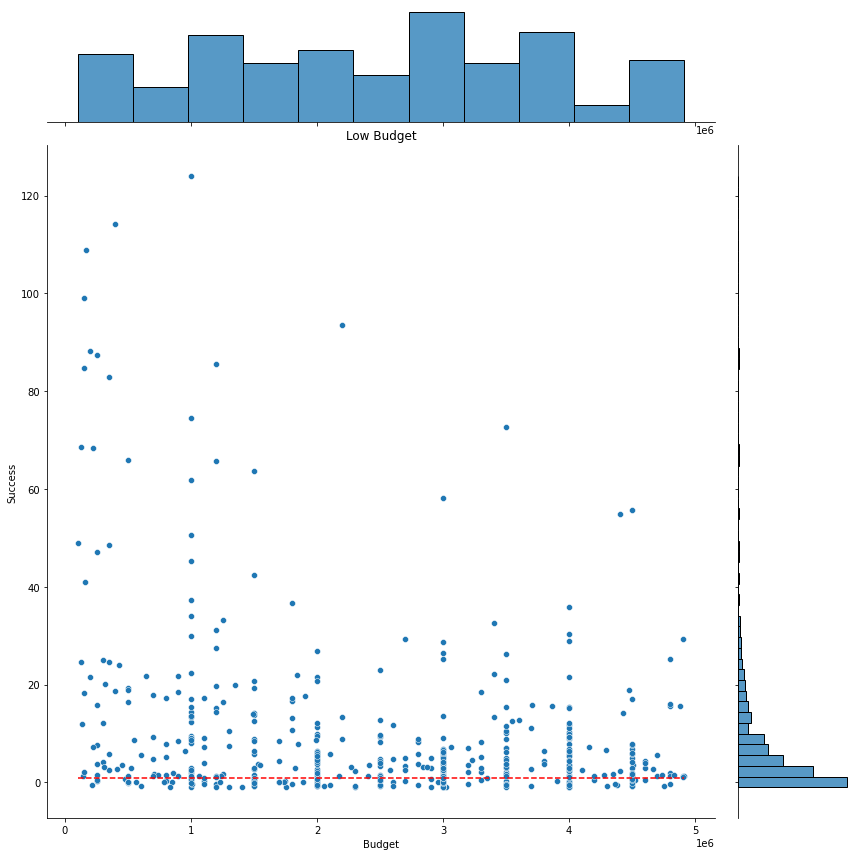

In [37]:
# Distribution of Success of High budget film
f = plt.figure(figsize=(30, 16))
sb.jointplot(data = low_budget, x = "Budget", y = "Success", height = 12)

#plt.plot([range of x], [range of y], style, color)
plt.plot([low_budget['Budget'].min(),low_budget['Budget'].max()],[1,1],'--',color='Red')
plt.title("Low Budget")
plt.savefig("plots\LowBudgetvsSuccess_plot.png")

From this plot, it can be seen that lower budget films(<5mil) have less movies under the threshold(Success<1) than higher budget movies. 

In [38]:
# Comparison of Successful vs Unsuccessful
low_budget_success = low_budget['Successful']
low_budget_success.value_counts()

True     384
False    143
Name: Successful, dtype: int64

<Figure size 2160x1152 with 0 Axes>

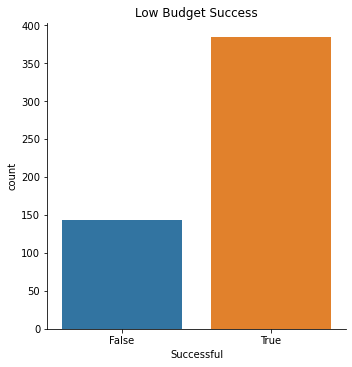

In [39]:
# Plotting
f = plt.figure(figsize=(30, 16))
sb.catplot(x = 'Successful',data = low_budget, kind = "count", orient ="h")
plt.title("Low Budget Success")
plt.savefig("plots/low_budget_success.png") #Save plot

With more than twice as many successful movies than unsuccessful movies, it goes to show that low budget films **does not** equate to unsuccessful film and that the correlation might be that higher budget movies have a higher chance of failure instead

---

<br>

<h1><font color=Blue> 3. Machine Learning </h1>

<h3>Table of Contents</h3>

<br>

<b>Models used</b>
<ol>
    <li>Decision Tree Classifier</li>
    <li>Random Forest Classifier</li>
    <li>TPOT Classifier </li>
</ol>
<br>

<b>Model Optimization</b>
<ol>
    <li>Manually Find Best Parameter Value</li>
    <li>GridSearchCV</li>
    <li>Tpot vs GridSearchCV</li>
</ol>

---

#### Creating New Dataset

As `Casts` and `Genres` are categorical data, they are stored as strings<br>
- For example genres = `'["Adventure","Action"]`, therefore genres[0] will output `[`
- Need to create individual columns for each genre <br>

| Adventure | Action | Drama |...|
| :- | :- | :- | :- |
|1|0|1|...|
|0|0|1|...|
|1|1|0|...|

<br>

- For `Genres`, check whether Movie contains the top 1000 cast
- create a column that shows whether it has popular cast <br>

| Popular Cast | 
| --- |
| 1 |
| 0 |
| 0 |
| 1 |


---

<br>

### Genre Appending

In [40]:
# Creating dictionary of genres
genre_ml_dict = {}
for genre in Genre_df.columns:
    genre_ml_dict[genre] = []

# looping through movie data to append value
for i,string_rows in enumerate(movie_data['Genres']) :
    list_row = string_to_list(string_rows)
    
    # loop through genre dictionary
    for genre in genre_ml_dict:
        if genre in list_row :
            genre_ml_dict[genre].append(1)
        else :
            genre_ml_dict[genre].append(0)

# Dataframe of only genres
genre_ml_df = pd.DataFrame(genre_ml_dict)
genre_ml_df

,Adventure,Action,Thriller,Comedy,Drama,Romance,History,War,ScienceFiction,Family,Fantasy,Crime,Horror,Mystery,Music,Animation,Western,Documentary,TVMovie,Genreless
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5335,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
5336,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5337,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5338,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [41]:
# Join the genre dataframe with main dataframe
ml_df = movie_data.join(genre_ml_df)
ml_df

,Name of Movie,Genres,Budget,Casts,Vote Count,Vote Average,Revenue,Gen,Profit,Success,...,Fantasy,Crime,Horror,Mystery,Music,Animation,Western,Documentary,TVMovie,Genreless
0,Raiders of the Lost Ark,"['Adventure', 'Action']",18000000,"['Harrison Ford', 'Karen Allen', 'Paul Freeman...",10400,7.922,389925971,X,371925971,20.6626,...,0,0,0,0,0,0,0,0,0,0
1,For Your Eyes Only,"['Adventure', 'Action', 'Thriller']",28000000,"['Roger Moore', 'Carole Bouquet', 'Lynn-Holly ...",1478,6.477,195312802,X,167312802,5.9755,...,0,0,0,0,0,0,0,0,0,0
2,Porky's,['Comedy'],4000000,['Kim Cattrall'],690,6.419,125728258,X,121728258,30.4321,...,0,0,0,0,0,0,0,0,0,0
3,On Golden Pond,"['Adventure', 'Drama', 'Romance']",15000000,"['Henry Fonda', 'Jane Fonda', 'Dabney Coleman']",359,7.333,119285432,X,104285432,6.9524,...,0,0,0,0,0,0,0,0,0,0
4,Arthur,"['Comedy', 'Drama', 'Romance']",7000000,"['Paul Gleason', 'Mark Margolis']",335,6.530,95461682,X,88461682,12.6374,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5335,The King's Daughter,"['Fantasy', 'Drama', 'Romance', 'History']",40500000,"['Pierce Brosnan', 'Kaya Scodelario', 'Benjami...",574,7.251,2182492,Z,-38317508,-0.9461,...,1,0,0,0,0,0,0,0,0,0
5336,Infinite Storm,"['Drama', 'Thriller']",4749917,"['Naomi Watts', ""Denis O'Hare""]",90,6.206,1564696,Z,-3185221,-0.6706,...,0,0,0,0,0,0,0,0,0,0
5337,Les passagers de la nuit,['Drama'],4300000,"['Charlotte Gainsbourg', 'Emmanuelle Béart']",44,7.023,1396831,Z,-2903169,-0.6752,...,0,0,0,0,0,0,0,0,0,0
5338,Terrifier 2,"['Horror', 'Thriller']",250000,"['Lauren LaVera', 'David Howard Thornton', 'Gr...",5,7.000,1200000,Z,950000,3.8000,...,0,0,1,0,0,0,0,0,0,0


<br>

### Top 700 cast column

In [42]:
top_casts = list(cast_df[:700].index)

popular_cast_list = []

for i,string_rows in enumerate(movie_data['Casts']) :
    list_row = string_to_list(string_rows)
    common_names = [name for name in list_row if name in top_casts] # if names in list_rows exists in top 1000
    if common_names :
        popular_cast_list.append(1)
    else :
        popular_cast_list.append(0)

ml_df['Popular Casts'] = popular_cast_list
ml_df

,Name of Movie,Genres,Budget,Casts,Vote Count,Vote Average,Revenue,Gen,Profit,Success,...,Crime,Horror,Mystery,Music,Animation,Western,Documentary,TVMovie,Genreless,Popular Casts
0,Raiders of the Lost Ark,"['Adventure', 'Action']",18000000,"['Harrison Ford', 'Karen Allen', 'Paul Freeman...",10400,7.922,389925971,X,371925971,20.6626,...,0,0,0,0,0,0,0,0,0,1
1,For Your Eyes Only,"['Adventure', 'Action', 'Thriller']",28000000,"['Roger Moore', 'Carole Bouquet', 'Lynn-Holly ...",1478,6.477,195312802,X,167312802,5.9755,...,0,0,0,0,0,0,0,0,0,1
2,Porky's,['Comedy'],4000000,['Kim Cattrall'],690,6.419,125728258,X,121728258,30.4321,...,0,0,0,0,0,0,0,0,0,0
3,On Golden Pond,"['Adventure', 'Drama', 'Romance']",15000000,"['Henry Fonda', 'Jane Fonda', 'Dabney Coleman']",359,7.333,119285432,X,104285432,6.9524,...,0,0,0,0,0,0,0,0,0,0
4,Arthur,"['Comedy', 'Drama', 'Romance']",7000000,"['Paul Gleason', 'Mark Margolis']",335,6.530,95461682,X,88461682,12.6374,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5335,The King's Daughter,"['Fantasy', 'Drama', 'Romance', 'History']",40500000,"['Pierce Brosnan', 'Kaya Scodelario', 'Benjami...",574,7.251,2182492,Z,-38317508,-0.9461,...,0,0,0,0,0,0,0,0,0,1
5336,Infinite Storm,"['Drama', 'Thriller']",4749917,"['Naomi Watts', ""Denis O'Hare""]",90,6.206,1564696,Z,-3185221,-0.6706,...,0,0,0,0,0,0,0,0,0,1
5337,Les passagers de la nuit,['Drama'],4300000,"['Charlotte Gainsbourg', 'Emmanuelle Béart']",44,7.023,1396831,Z,-2903169,-0.6752,...,0,0,0,0,0,0,0,0,0,0
5338,Terrifier 2,"['Horror', 'Thriller']",250000,"['Lauren LaVera', 'David Howard Thornton', 'Gr...",5,7.000,1200000,Z,950000,3.8000,...,0,1,0,0,0,0,0,0,0,0


In [43]:
ml_df['Popular Casts'].value_counts()

1    4484
0     856
Name: Popular Casts, dtype: int64

There are 4483 movies with popular casts while only 856 movies without.

---

<br>

### 3.1 Decision Tree Classifier

In [116]:
# Import Decision Tree Classifier model from Scikit-Learn
from sklearn.tree import DecisionTreeClassifier

# Plot the trained Decision Tree
from sklearn.tree import plot_tree

# Import essential models and functions from sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# For Exporting trained models
import pickle

<p>For train-test split, change <font color=Red>random_state</font> to try different mix up the dataset. Every random_state is a specific combination of train-test data, hence change the number to <b>any integer</b> and test the accuracy. Remember the state with the best accuracy and always use that state</p>


In [117]:
# Columns Required
columns_required = [idx for idx in ml_df.columns[11:]] # All columns from index 11 and Budget
columns_required.append('Budget') # Adding Budget to part of dataframe column

# Extract Response and Predictors
y = pd.DataFrame(ml_df['Successful'])
X = pd.DataFrame(ml_df[columns_required])

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 73)

In [127]:
# Creating Decision Tree Model
dectree = DecisionTreeClassifier(max_depth = 100)  # create the decision tree model according to parameters
dectree.fit(X_train, y_train)                    # train the decision tree model

# Exporting Model so that do not need to re-train model with each refresh
with open('dectree_untuned.pkl', 'wb') as f: 
    pickle.dump(dectree , f)

In [398]:
# Plotting the Tree for visualisation
# Do NOT plot if more than depth of 4 because it lags and nothing can be seen anyways
f = plt.figure(figsize=(24,24))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=X_train.columns, 
          class_names=["0","1"])

[Text(605.7195538774868, 1286.0022857142858, 'Budget <= 11159215.0\ngini = 0.497\nsamples = 3738\nvalue = [1735, 2003]\nclass = 1'),
 Text(155.84822492654325, 1248.7268571428572, 'Budget <= 5054033.0\ngini = 0.46\nsamples = 1000\nvalue = [358, 642]\nclass = 1'),
 Text(72.50791560069912, 1211.4514285714286, 'Popular Casts <= 0.5\ngini = 0.416\nsamples = 438\nvalue = [129, 309]\nclass = 1'),
 Text(43.79308493122927, 1174.1760000000002, 'Adventure <= 0.5\ngini = 0.331\nsamples = 191\nvalue = [40, 151]\nclass = 1'),
 Text(42.70758631171003, 1136.9005714285715, 'Western <= 0.5\ngini = 0.353\nsamples = 175\nvalue = [40, 135]\nclass = 1'),
 Text(41.62208769219079, 1099.625142857143, 'Music <= 0.5\ngini = 0.348\nsamples = 174\nvalue = [39, 135]\nclass = 1'),
 Text(36.56773474505434, 1062.3497142857143, 'ScienceFiction <= 0.5\ngini = 0.337\nsamples = 168\nvalue = [36, 132]\nclass = 1'),
 Text(29.715524709339146, 1025.074285714286, 'Romance <= 0.5\ngini = 0.32\nsamples = 155\nvalue = [31, 124]\n

Error in callback <function flush_figures at 0x000002014C34A670> (for post_execute):


KeyboardInterrupt: 

Text(0.5, 1.0, 'Test Data Confusion Matrix')

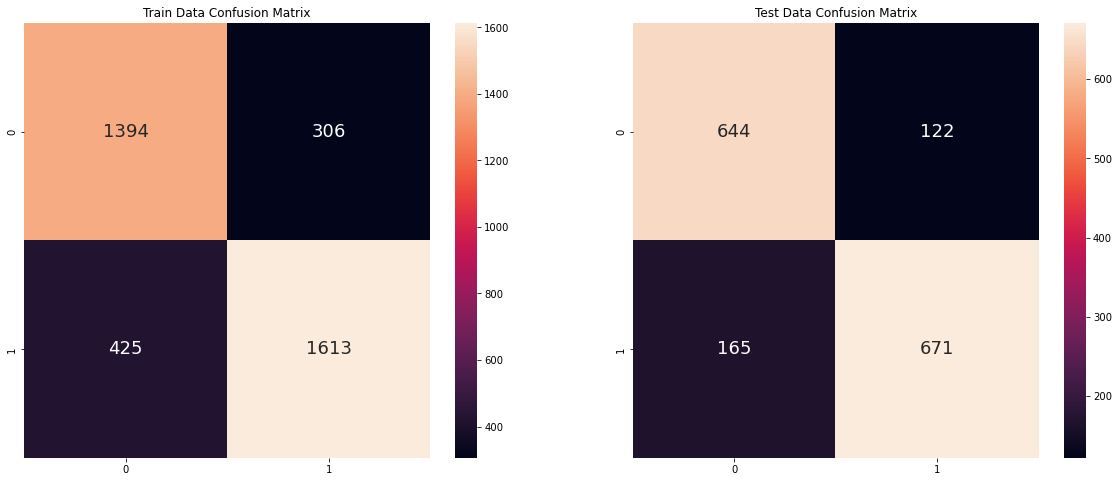

In [132]:
# Predict Legendary values corresponding to Total
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)


# Confusion Matrix
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Plot the Confusion Matrix
fig, ax = plt.subplots(1,2,figsize=(20, 8))

# CM for Train Data
sb.heatmap(cm_train,
           annot = True, fmt=".0f", annot_kws={"size": 18},ax=ax[0])
ax[0].set_title("Train Data Confusion Matrix")

# CM for Test Data
sb.heatmap(cm_test,
           annot = True, fmt=".0f", annot_kws={"size": 18},ax=ax[1])
ax[1].set_title("Test Data Confusion Matrix")

### Classification Accuracy
- `TPR = TP / (TP + FN)` : True Positive Rate = True Positives / All Positives
- `TNR = TN / (TN + FP)` : True Negative Rate = True Negatives / All Negatives
- `FPR = FP / (TN + FP)` : False Positive Rate = False Positives / All Negatives
- `FNR = FN / (TP + FN)` : False Negative Rate = False Negatives / All Positives

In [133]:
# Number of Rows for each dataset
length_train = X_train.shape[0] 
length_test = X_test.shape[0]

# Train data accuracy
tn_train, fp_train, fn_train, tp_train = cm_train[0][0],cm_train[0][1],cm_train[1][0],cm_train[1][1]

# Accuracy Measures
train_tr_neg = tn_train/(tn_train+fp_train)
train_fa_pos = (fp_train/(tn_train+fp_train))
train_fa_neg = (fn_train/(fn_train+tp_train))
train_tr_pos = (tp_train/(fn_train+tp_train))
train_acc = (tp_train+tn_train)/length_train
train_inacc = 1 - train_acc

# Test data accuracy
tn_test, fp_test, fn_test, tp_test= cm_test[0][0],cm_test[0][1],cm_test[1][0],cm_test[1][1]

# Accuracy Measures
test_tr_neg = tn_test/(tn_test+fp_test)
test_fa_pos = (fp_test/(tn_train+fp_test))
test_fa_neg = (fn_test/(fn_test+tp_test))
test_tr_pos = (tp_test/(fn_test+tp_test))
test_acc = (tp_test+tn_test)/length_test
test_inacc = 1 - test_acc

In [134]:
# Printing Dataframe of accuracy measures

# Dictionary of measures
accuracy_dict = {'class_acc': ['tr_neg', 'fa_pos', 'fa_neg','tr_pos', 'acc', 'inacc'],
       'train': [train_tr_neg, train_fa_pos, train_fa_neg,train_tr_pos, train_acc, train_inacc],
       'test': [test_tr_neg, test_fa_pos, test_fa_neg,test_tr_pos, test_acc, test_inacc]}

# Dictionary to dataframe
accuracy_df = pd.DataFrame(accuracy_dict)
accuracy_df

,class_acc,train,test
0,tr_neg,0.820000,0.840731
1,fa_pos,0.180000,0.080475
2,fa_neg,0.208538,0.197368
3,tr_pos,0.791462,0.802632
4,acc,0.804441,0.820849
5,inacc,0.195559,0.179151


<p>With a depth of <b>100</b>, the accuracy on the test data is around <u>56%</u>, there is <b>not enough evidence</b> to show a direct impact on <b>Success</b> by the factors mentioned. However, the train data accuracy is <u>91%</u> which would mean that there is some correlation between the factors and its "Successful-ness"

---

<br>

### 3.2 Random Forest Classifier

In [60]:
from sklearn.ensemble import RandomForestClassifier

# Creating the model
randomforest = RandomForestClassifier(max_depth=100, random_state=0, n_estimators=150)
randomforest.fit(X_train, y_train['Successful']) #Used y_train['Successful'] instead of just y_train because of error, requires 1-D array

# Exporting Model so that do not need to re-train model with each refresh
with open('randomforest_untuned.pkl', 'wb') as f: 
    pickle.dump(randomforest , f)

Text(0.5, 1.0, 'Test Data Confusion Matrix')

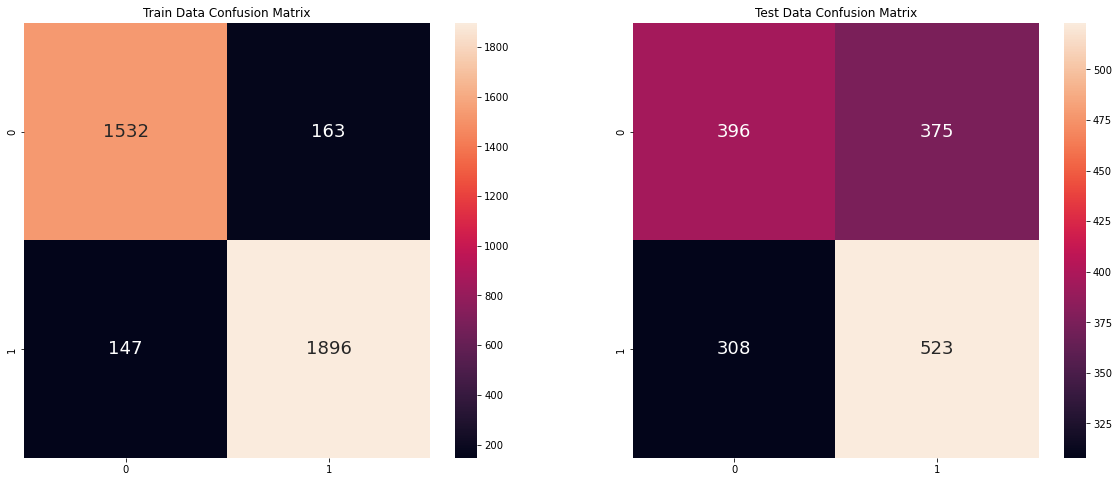

In [61]:
# Predicting Results
y_train_pred = randomforest.predict(X_train)
y_test_pred = randomforest.predict(X_test)

# Confusion Matrix
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Plot the Confusion Matrix
fig, ax = plt.subplots(1,2,figsize=(20, 8))

# CM for Train Data
sb.heatmap(cm_train,
           annot = True, fmt=".0f", annot_kws={"size": 18},ax=ax[0])
ax[0].set_title("Train Data Confusion Matrix")

# CM for Test Data
sb.heatmap(cm_test,
           annot = True, fmt=".0f", annot_kws={"size": 18},ax=ax[1])
ax[1].set_title("Test Data Confusion Matrix")

In [62]:
# Number of Rows for each dataset
length_train = X_train.shape[0] 
length_test = X_test.shape[0]

# Train data accuracy
tn_train, fp_train, fn_train, tp_train = cm_train[0][0],cm_train[0][1],cm_train[1][0],cm_train[1][1]

# Accuracy Measures
train_tr_neg = tn_train/(tn_train+fp_train)
train_fa_pos = (fp_train/(tn_train+fp_train))
train_fa_neg = (fn_train/(fn_train+tp_train))
train_tr_pos = (tp_train/(fn_train+tp_train))
train_acc = (tp_train+tn_train)/length_train
train_inacc = 1 - train_acc

# Test data accuracy
tn_test, fp_test, fn_test, tp_test= cm_test[0][0],cm_test[0][1],cm_test[1][0],cm_test[1][1]

# Accuracy Measures
test_tr_neg = tn_test/(tn_test+fp_test)
test_fa_pos = (fp_test/(tn_train+fp_test))
test_fa_neg = (fn_test/(fn_test+tp_test))
test_tr_pos = (tp_test/(fn_test+tp_test))
test_acc = (tp_test+tn_test)/length_test
test_inacc = 1 - test_acc

In [63]:
# Printing Dataframe of accuracy measures

# Dictionary of measures
accuracy_dict = {'class_acc': ['tr_neg', 'fa_pos', 'fa_neg','tr_pos', 'acc', 'inacc'],
       'train': [train_tr_neg, train_fa_pos, train_fa_neg,train_tr_pos, train_acc, train_inacc],
       'test': [test_tr_neg, test_fa_pos, test_fa_neg,test_tr_pos, test_acc, test_inacc]}

# Dictionary to dataframe
accuracy_df = pd.DataFrame(accuracy_dict)
accuracy_df

,class_acc,train,test
0,tr_neg,0.903835,0.513619
1,fa_pos,0.096165,0.196644
2,fa_neg,0.071953,0.370638
3,tr_pos,0.928047,0.629362
4,acc,0.917068,0.573658
5,inacc,0.082932,0.426342


<p>With a depth of <b>100</b>, the accuracy on the test data is around <u>57%</u>, there is <b>not enough evidence</b> to show a direct impact on <b>Success</b> by the factors mentioned however, as the accuracy of train data is around 91.5%, it shows that there is a correlation and therefore could be tuned to achieve better results</p>

---

<br>

### 3.3 TPOT Classifier
- Tpot is an automated machine learning package in python that uses genetic programming concepts to optimize the machine learning pipeline
- Automates the machine learning by intelligently exploring thousands of the possible to find the best possible parameter that suits data
- [TPOT Documentation Site](http://epistasislab.github.io/tpot/api/)
- [RepeatedKFolds Documentation Site](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html)

In [204]:
# Required libraries
from tpot import TPOTClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_regression
from sklearn.linear_model import Lasso
"""For Optimization of ML by KFolds"""
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

# 1st Tpot try
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=1)
tpot = TPOTClassifier(template = 'Classifier', generations=20, population_size=200, scoring='neg_mean_squared_error', cv=cv, verbosity=2, random_state=1, n_jobs=-1)

In [206]:
tpot.fit(X_train, y_train['Successful'])


Generation 1 - Current best internal CV score: -0.4021105455690857

Generation 2 - Current best internal CV score: -0.4021105455690857

Generation 3 - Current best internal CV score: -0.40186958171366394

Generation 4 - Current best internal CV score: -0.40186958171366394


TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: XGBClassifier(input_matrix, learning_rate=0.1, max_depth=1, min_child_weight=18, n_estimators=100, n_jobs=1, subsample=0.8500000000000001, verbosity=0)


TPOTClassifier(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=1),
               generations=20, n_jobs=-1, population_size=200, random_state=1,
               scoring='neg_mean_squared_error', template='Classifier',
               verbosity=2)

In [211]:
TPOT_model = model.fitted_pipeline_
with open('tpot_new.pkl', 'wb') as f: #Exporting model to a pickle file so that there is no need to re-train model
    pickle.dump(TPOT_model , f)

Text(0.5, 1.0, 'Test Data Confusion Matrix')

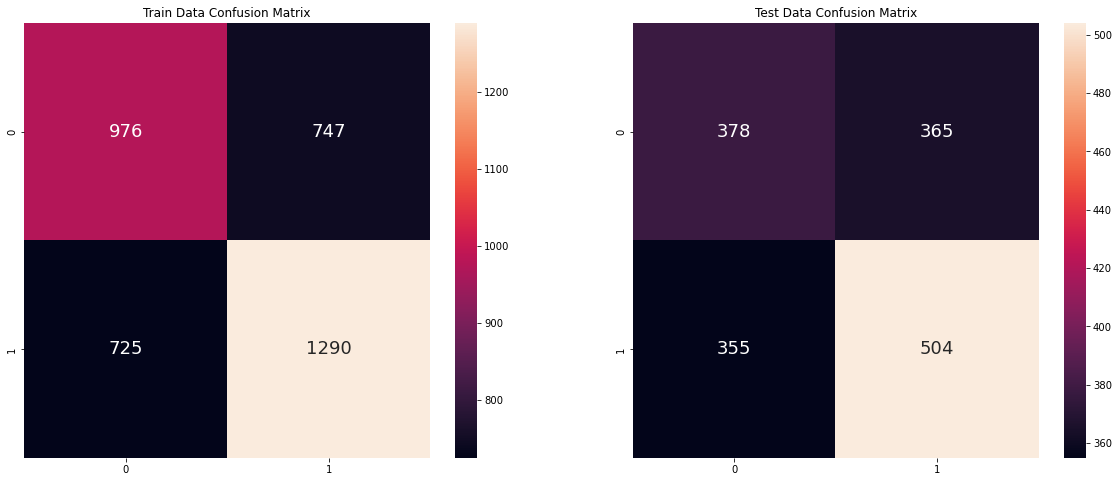

In [207]:
# Predicting Results
y_train_pred = tpot.predict(X_train)
y_test_pred = tpot.predict(X_test)

# Confusion Matrix
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Plot the Confusion Matrix
fig, ax = plt.subplots(1,2,figsize=(20, 8))

# CM for Train Data
sb.heatmap(cm_train,
           annot = True, fmt=".0f", annot_kws={"size": 18},ax=ax[0])
ax[0].set_title("Train Data Confusion Matrix")

# CM for Test Data
sb.heatmap(cm_test,
           annot = True, fmt=".0f", annot_kws={"size": 18},ax=ax[1])
ax[1].set_title("Test Data Confusion Matrix")

In [208]:
# Number of Rows for each dataset
length_train = X_train.shape[0] 
length_test = X_test.shape[0]

# Train data accuracy
tn_train, fp_train, fn_train, tp_train = cm_train[0][0],cm_train[0][1],cm_train[1][0],cm_train[1][1]

# Accuracy Measures
train_tr_neg = tn_train/(tn_train+fp_train)
train_fa_pos = (fp_train/(tn_train+fp_train))
train_fa_neg = (fn_train/(fn_train+tp_train))
train_tr_pos = (tp_train/(fn_train+tp_train))
train_acc = (tp_train+tn_train)/length_train
train_inacc = 1 - train_acc

# Test data accuracy
tn_test, fp_test, fn_test, tp_test= cm_test[0][0],cm_test[0][1],cm_test[1][0],cm_test[1][1]

# Accuracy Measures
test_tr_neg = tn_test/(tn_test+fp_test)
test_fa_pos = (fp_test/(tn_train+fp_test))
test_fa_neg = (fn_test/(fn_test+tp_test))
test_tr_pos = (tp_test/(fn_test+tp_test))
test_acc = (tp_test+tn_test)/length_test
test_inacc = 1 - test_acc

In [209]:
# Printing Dataframe of accuracy measures

# Dictionary of measures
accuracy_dict = {'class_acc': ['tr_neg', 'fa_pos', 'fa_neg','tr_pos', 'acc', 'inacc'],
       'train': [train_tr_neg, train_fa_pos, train_fa_neg,train_tr_pos, train_acc, train_inacc],
       'test': [test_tr_neg, test_fa_pos, test_fa_neg,test_tr_pos, test_acc, test_inacc]}

# Dictionary to dataframe
accuracy_df = pd.DataFrame(accuracy_dict)
accuracy_df

,class_acc,train,test
0,tr_neg,0.566454,0.508748
1,fa_pos,0.433546,0.272185
2,fa_neg,0.359801,0.413271
3,tr_pos,0.640199,0.586729
4,acc,0.606207,0.550562
5,inacc,0.393793,0.449438


<br>

After training and optimising a model using TPOT, the accuracy of the test data **remains similar** at <u>55%</u> accuracy. 

<br>
<br>

<h2><font color=Blue>Optimising Models</h2>

#### Decision Tree Model

In [120]:
# Creating a function to call for prediction

def Dec_tree_pred(max_depth, X_train, y_train, X_test, y_test):
    # Creating Decision Tree Model
    dectree = DecisionTreeClassifier(max_depth = max_depth)  # create the decision tree model according to parameters
    dectree.fit(X_train, y_train)                    # train the decision tree model
    
    # Predict Legendary values corresponding to Total
    y_train_pred = dectree.predict(X_train)
    y_test_pred = dectree.predict(X_test)


    # Confusion Matrix
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)
    
    # Number of Rows for each dataset
    length_train = X_train.shape[0] 
    length_test = X_test.shape[0]

    # Train data accuracy
    tn_train, fp_train, fn_train, tp_train = cm_train[0][0],cm_train[0][1],cm_train[1][0],cm_train[1][1]

    # Accuracy Measures
    train_tr_neg = tn_train/(tn_train+fp_train)
    train_fa_pos = (fp_train/(tn_train+fp_train))
    train_fa_neg = (fn_train/(fn_train+tp_train))
    train_tr_pos = (tp_train/(fn_train+tp_train))
    train_acc = (tp_train+tn_train)/length_train
    train_inacc = 1 - train_acc

    # Test data accuracy
    tn_test, fp_test, fn_test, tp_test= cm_test[0][0],cm_test[0][1],cm_test[1][0],cm_test[1][1]

    # Accuracy Measures
    test_tr_neg = tn_test/(tn_test+fp_test)
    test_fa_pos = (fp_test/(tn_train+fp_test))
    test_fa_neg = (fn_test/(fn_test+tp_test))
    test_tr_pos = (tp_test/(fn_test+tp_test))
    test_acc = (tp_test+tn_test)/length_test
    test_inacc = 1 - test_acc
    
    # Dictionary of measures
    accuracy_dict = {'class_acc': ['tr_neg', 'fa_pos', 'fa_neg','tr_pos', 'acc', 'inacc'],
           'train': [train_tr_neg, train_fa_pos, train_fa_neg,train_tr_pos, train_acc, train_inacc],
           'test': [test_tr_neg, test_fa_pos, test_fa_neg,test_tr_pos, test_acc, test_inacc]}

    # Dictionary to dataframe
    accuracy_df = pd.DataFrame(accuracy_dict)
    
    return test_acc, accuracy_df, dectree

In [121]:
# Manually looping Through all the max_depth to see which produces best results
max_depth_range = [2,3,4,5,7,10,20,50,60,75,80,100,125,150,175,200,250,300,400,500,600]

max_acc = 0
acc_list = [] # For plotting
for depth in max_depth_range:
    acc, acc_df, dec_model = Dec_tree_pred(depth, X_train, y_train, X_test, y_test)
    acc_list.append(acc)
    if acc > max_acc :
        max_acc = acc
        best_df = acc_df
        best_depth = depth
        
        #Saving Tuned Model
        with open('dectree_tuned.pkl', 'wb') as f:
            pickle.dump(dec_model , f)

print(f"Best Accuracy : {max_acc}, best depth : {best_depth}")
best_df

Best Accuracy : 0.5736579275905118, best depth : 10


,class_acc,train,test
0,tr_neg,0.678235,0.588773
1,fa_pos,0.321765,0.214578
2,fa_neg,0.322866,0.440191
3,tr_pos,0.677134,0.559809
4,acc,0.677635,0.573658
5,inacc,0.322365,0.426342


Text(0.5, 0, 'Max depth')

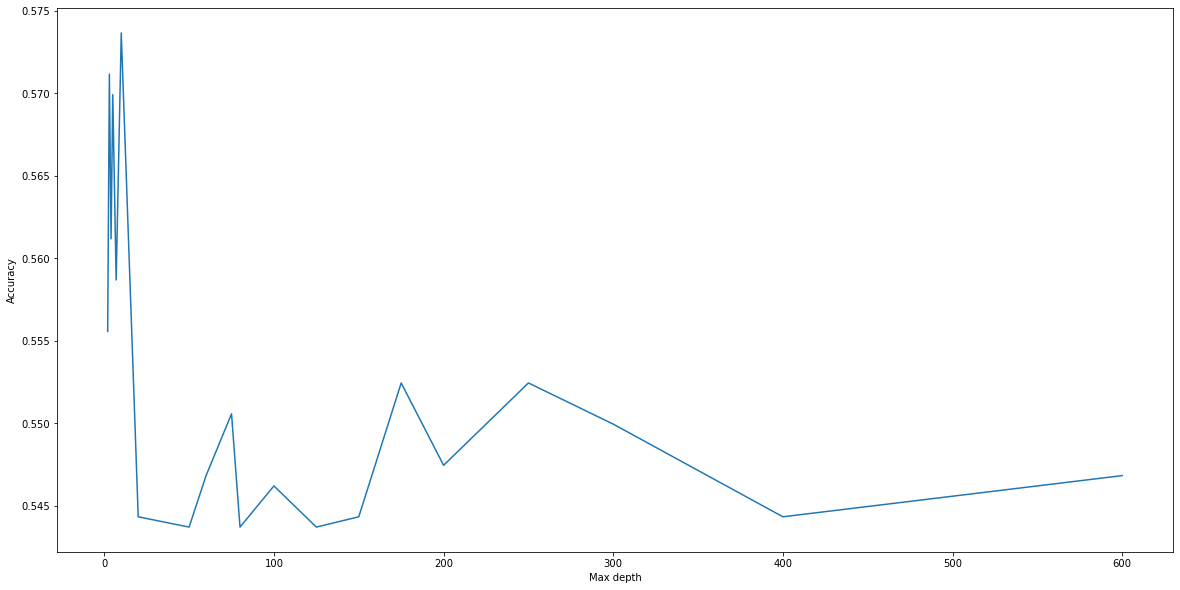

In [122]:
f = plt.figure(figsize=(20,10))
plt.plot(max_depth_range,acc_list)
plt.ylabel("Accuracy")
plt.xlabel("Max depth")

As can be seen from the accuracy plot, we can see that after max_depth > 80, the graph starts to saturate and max_depth does not affect the accuracy of the model as much. Therefore, we can conclude that **max depth > 100** is the optimal depth for an accurate prediction

---

<br>
<br>


#### Random Forest Model
- Finding the best 3 values for each parameter
- Using `GridSearchCV` to choose the best value for the best accuracy

In [73]:
# Creating a function to call for prediction

def Rand_For_pred(X_train, y_train, X_test, y_test, max_depth=100, n_estimators=100, min_samples_leaf=1, 
                  min_samples_split=2, bootstrap=True, random_state=0, max_features=None):
    # Creating the model
    clf = RandomForestClassifier( max_depth=max_depth,
                                 n_estimators=n_estimators,
                                 min_samples_leaf=min_samples_leaf,
                                 min_samples_split=min_samples_split, 
                                 bootstrap=bootstrap,
                                 random_state= random_state,
                                 max_features=max_features)
    
    clf.fit(X_train, y_train['Successful']) #Used y_train['Successful'] instead of just y_train because of error, requires 1-D array
    
    # Predict Legendary values corresponding to Total
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)


    # Confusion Matrix
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)
    
    # Number of Rows for each dataset
    length_train = X_train.shape[0] 
    length_test = X_test.shape[0]

    # Train data accuracy
    tn_train, fp_train, fn_train, tp_train = cm_train[0][0],cm_train[0][1],cm_train[1][0],cm_train[1][1]

    # Accuracy Measures
    train_tr_neg = tn_train/(tn_train+fp_train)
    train_fa_pos = (fp_train/(tn_train+fp_train))
    train_fa_neg = (fn_train/(fn_train+tp_train))
    train_tr_pos = (tp_train/(fn_train+tp_train))
    train_acc = (tp_train+tn_train)/length_train
    train_inacc = 1 - train_acc

    # Test data accuracy
    tn_test, fp_test, fn_test, tp_test= cm_test[0][0],cm_test[0][1],cm_test[1][0],cm_test[1][1]

    # Accuracy Measures
    test_tr_neg = tn_test/(tn_test+fp_test)
    test_fa_pos = (fp_test/(tn_train+fp_test))
    test_fa_neg = (fn_test/(fn_test+tp_test))
    test_tr_pos = (tp_test/(fn_test+tp_test))
    test_acc = (tp_test+tn_test)/length_test
    test_inacc = 1 - test_acc
    
    # Dictionary of measures
    accuracy_dict = {'class_acc': ['tr_neg', 'fa_pos', 'fa_neg','tr_pos', 'acc', 'inacc'],
           'train': [train_tr_neg, train_fa_pos, train_fa_neg,train_tr_pos, train_acc, train_inacc],
           'test': [test_tr_neg, test_fa_pos, test_fa_neg,test_tr_pos, test_acc, test_inacc]}

    # Dictionary to dataframe
    accuracy_df = pd.DataFrame(accuracy_dict)
    
    return test_acc, accuracy_df

<br>

#### max_depth 

In [74]:
# Manually looping Through all the max_depth to see which produces best results
max_depth_range = [2,3,4,5,7,10,20,50,60,75,80,100,125,150,175,200,250,300,400,500,600]

max_acc = 0
acc_depth_list = [] # For plotting
for depth in max_depth_range:
    acc, acc_df = Rand_For_pred(X_train, y_train, X_test, y_test,max_depth=depth)
    acc_depth_list.append(acc)
    if acc > max_acc :
        max_acc = acc
        best_df = acc_df
        best_depth = depth

print(f"Best Accuracy : {max_acc}, best depth : {best_depth}")
best_df

Best Accuracy : 0.5786516853932584, best depth : 20


,class_acc,train,test
0,tr_neg,0.900885,0.512322
1,fa_pos,0.099115,0.197583
2,fa_neg,0.072442,0.359807
3,tr_pos,0.927558,0.640193
4,acc,0.915463,0.578652
5,inacc,0.084537,0.421348


Text(0.5, 0, 'Max depth')

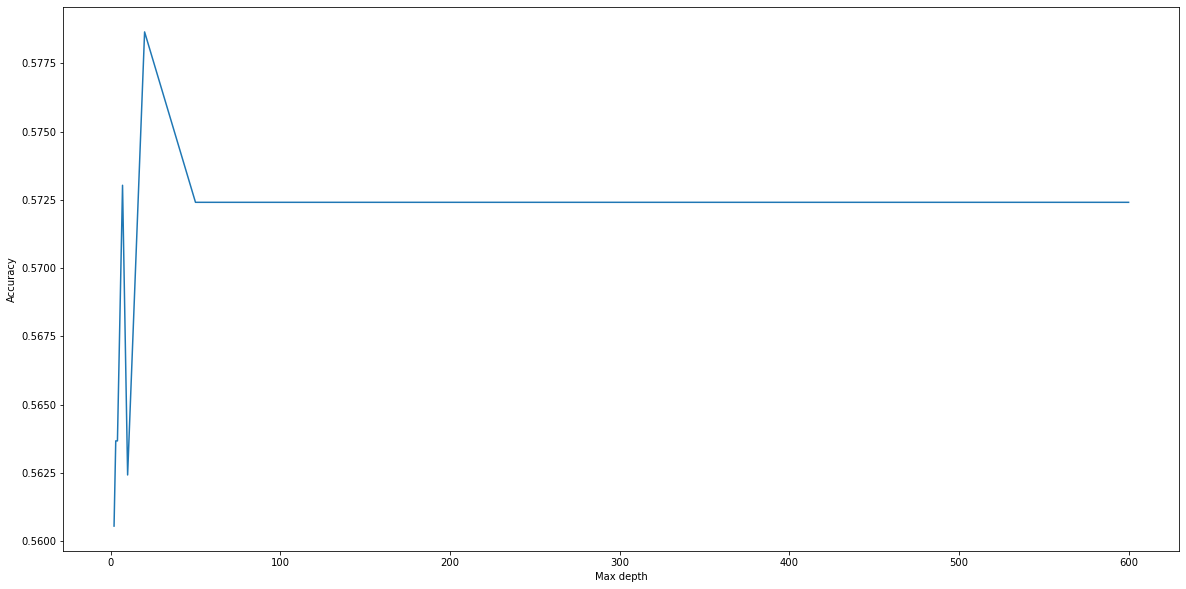

In [75]:
f = plt.figure(figsize=(20,10))
plt.plot(max_depth_range,acc_depth_list)
plt.ylabel("Accuracy")
plt.xlabel("Max depth")

<br>

#### n_estimators

In [325]:
n_estimators_range = [50,100,200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
    
max_acc = 0
acc_nest_list = [] # For plotting
for n_estimator in n_estimators_range:
    acc, acc_df = Rand_For_pred(X_train, y_train, X_test, y_test,n_estimators=n_estimator)
    acc_nest_list.append(acc)
    if acc > max_acc :
        max_acc = acc
        best_df = acc_df
        best_n_estimator = n_estimator

print(f"Best Accuracy : {max_acc}, best_n_estimator : {best_n_estimator}")
best_df

Best Accuracy : 0.5861423220973783, best_n_estimator : 100


,class_acc,train,test
0,tr_neg,0.907719,0.549125
1,fa_pos,0.092281,0.176409
2,fa_neg,0.078412,0.381839
3,tr_pos,0.921588,0.618161
4,acc,0.915195,0.586142
5,inacc,0.084805,0.413858


Text(0.5, 0, 'Max depth')

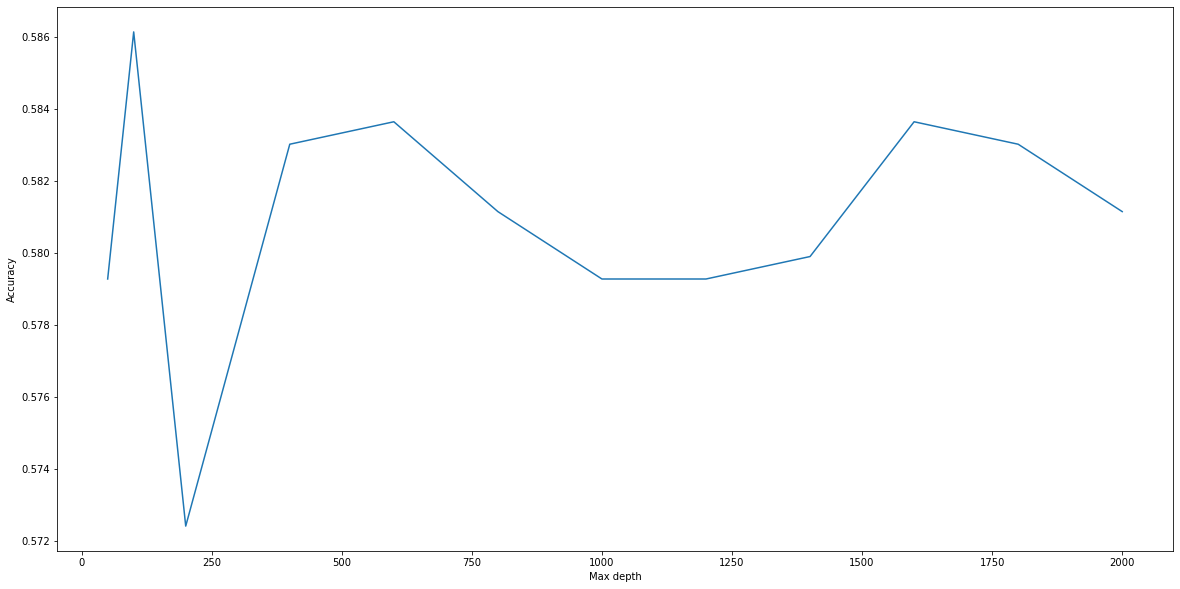

In [326]:
f = plt.figure(figsize=(20,10))
plt.plot(n_estimators_range,acc_nest_list)
plt.ylabel("Accuracy")
plt.xlabel("N estimator")

<br>

#### min samples leaf

In [444]:
min_samples_leaf_range = [1, 2, 4,8, 10, 15, 17, 19 ,23]

max_acc = 0
acc_samLeaf_list = [] # For plotting
for samp_leaf in min_samples_leaf_range:
    acc, acc_df = Rand_For_pred(X_train, y_train, X_test, y_test,min_samples_leaf=samp_leaf)
    acc_samLeaf_list.append(acc)
    if acc > max_acc :
        max_acc = acc
        best_df = acc_df
        best_min_samples_leaf = samp_leaf

print(f"Best Accuracy : {max_acc}, best min_samples_leaf : {best_min_samples_leaf}")
best_df

Best Accuracy : 0.6054931335830213, best min_samples_leaf : 4


,class_acc,train,test
0,tr_neg,0.605568,0.494609
1,fa_pos,0.394432,0.264271
2,fa_neg,0.198113,0.298837
3,tr_pos,0.801887,0.701163
4,acc,0.711343,0.605493
5,inacc,0.288657,0.394507


Text(0.5, 0, 'Max depth')

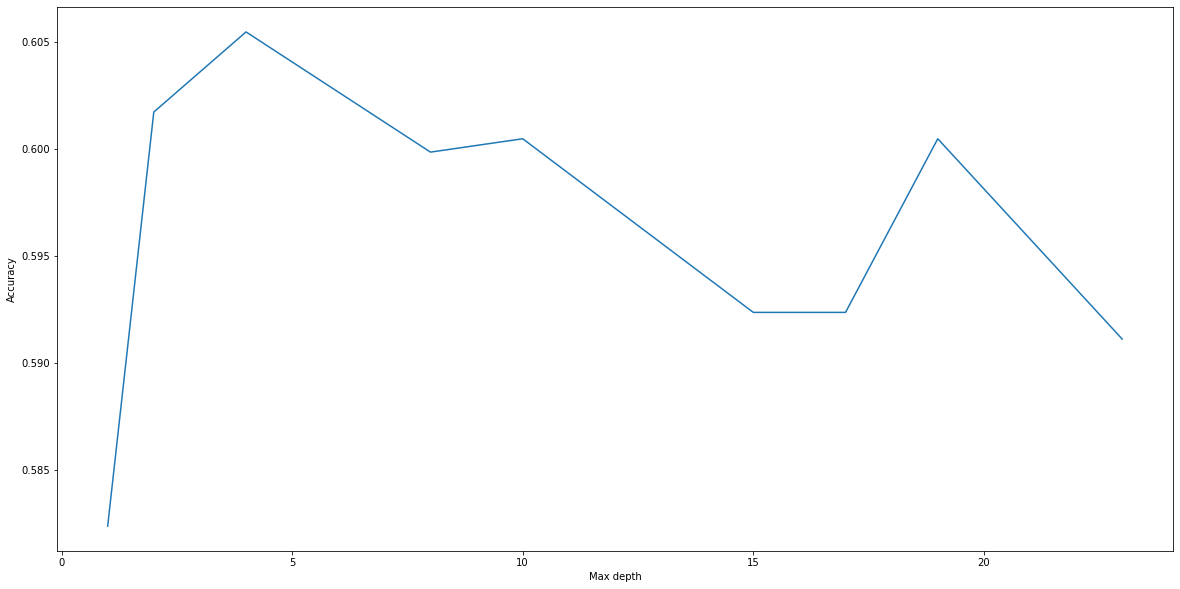

In [445]:
f = plt.figure(figsize=(20,10))
plt.plot(min_samples_leaf_range,acc_samLeaf_list)
plt.ylabel("Accuracy")
plt.xlabel("Min sample leaf")

<br>

#### min samples split

In [447]:
min_samples_split_range = [2, 4,8, 10, 15, 17, 19 ,23]

max_acc = 0
acc_samSplit_list = [] # For plotting
for split in min_samples_split_range:
    acc, acc_df = Rand_For_pred(X_train, y_train, X_test, y_test,min_samples_split=split)
    acc_samSplit_list.append(acc)
    if acc > max_acc :
        max_acc = acc
        best_df = acc_df
        best_min_samples_split = split

print(f"Best Accuracy : {max_acc}, best min_samples_split : {best_min_samples_split}")
best_df

Best Accuracy : 0.6092384519350812, best min_samples_split : 17


,class_acc,train,test
0,tr_neg,0.722158,0.528302
1,fa_pos,0.277842,0.219436
2,fa_neg,0.177259,0.320930
3,tr_pos,0.822741,0.679070
4,acc,0.776351,0.609238
5,inacc,0.223649,0.390762


Text(0.5, 0, 'Max depth')

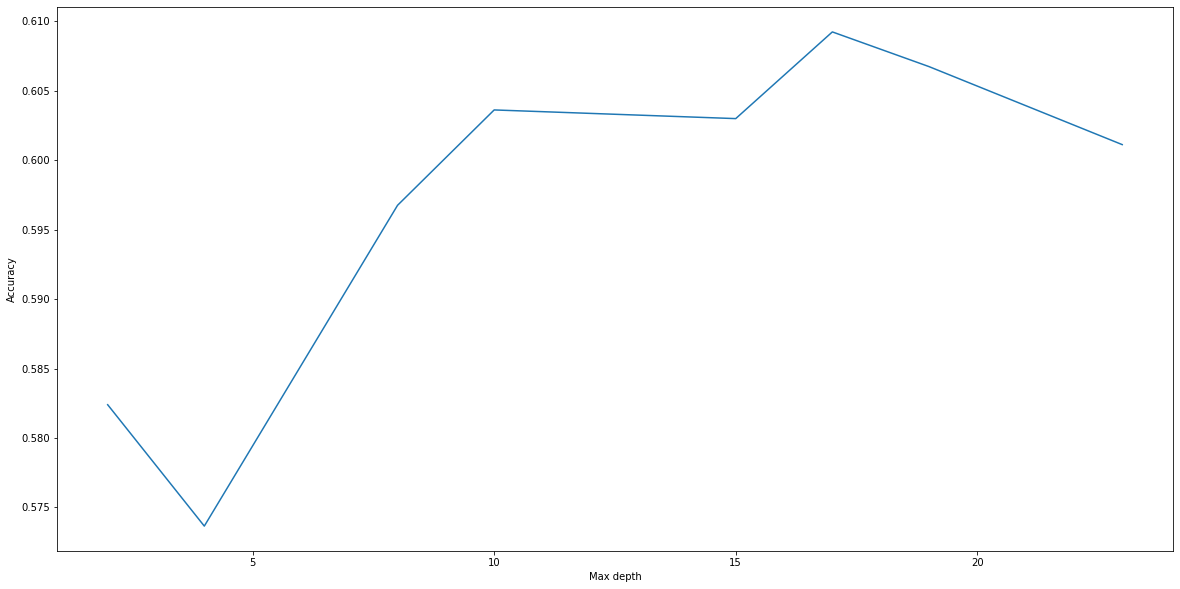

In [448]:
f = plt.figure(figsize=(20,10))
plt.plot(min_samples_split_range, acc_samSplit_list)
plt.ylabel("Accuracy")
plt.xlabel("Min sample split")

<br>

#### max features

In [453]:
max_features_range = [0.1,0.3,0.7,1,2,"sqrt","log2",None]

max_acc = 0
acc_max_features_list = [] # For plotting
for feature in max_features_range:
    acc, acc_df = Rand_For_pred(X_train, y_train, X_test, y_test,max_features=feature)
    acc_max_features_list.append(acc)
    if acc > max_acc :
        max_acc = acc
        best_df = acc_df
        best_max_features = feature

print(f"Best Accuracy : {max_acc}, best max_features : {feature}")
best_df

Best Accuracy : 0.5873907615480649, best max_features : None


,class_acc,train,test
0,tr_neg,0.892691,0.513477
1,fa_pos,0.107309,0.190000
2,fa_neg,0.058093,0.348837
3,tr_pos,0.941907,0.651163
4,acc,0.919208,0.587391
5,inacc,0.080792,0.412609


<br>

#### Random State

In [442]:
import random
rand_list = [random.randrange(0,1000) for i in range(50)]
rand_list

[948,
 22,
 426,
 857,
 938,
 569,
 944,
 657,
 102,
 190,
 644,
 741,
 880,
 303,
 123,
 760,
 340,
 917,
 738,
 996,
 728,
 512,
 958,
 990,
 432,
 519,
 849,
 932,
 686,
 194,
 310,
 290,
 601,
 996,
 903,
 511,
 866,
 963,
 517,
 402,
 603,
 873,
 35,
 491,
 248,
 761,
 816,
 413,
 424,
 680]

In [443]:
max_acc = 0
acc_rand_list = [] # For plotting
for ran_num in rand_list:
    acc, acc_df = Rand_For_pred(X_train, y_train, X_test, y_test,random_state=ran_num)
    acc_rand_list.append(acc)
    if acc > max_acc :
        max_acc = acc
        best_df = acc_df
        best_random_state = ran_num

print(f"Best Accuracy : {max_acc}, best random_state : {best_random_state}")
best_df

Best Accuracy : 0.5848938826466916, best random_state : 873


,class_acc,train,test
0,tr_neg,0.893852,0.516173
1,fa_pos,0.106148,0.188947
2,fa_neg,0.059086,0.355814
3,tr_pos,0.940914,0.644186
4,acc,0.919208,0.584894
5,inacc,0.080792,0.415106


<br>
<br>

### GridSearchCV
- Exhaustive search the best parameters
- Compare with Best tpot model

In [351]:
from sklearn.model_selection import GridSearchCV

In [369]:
# Function to get the top 3 most accurate value for a parameter
def top3params(params_list, acc_list ):
    sorted_acc_lst = sorted(acc_list, reverse=True)[:3] #Get top 3 most accurate
    
    duplicate_idx = 0 # to loop through same number e.g. acc = [0.63,0.73,0.63,0.80] ; 0.63 appear twice so have to find 2nd idx
    best_params = [] # List of best parameters
    for best_acc in sorted_acc_lst:
        index = acc_list.index(best_acc)
        value = params_list[index]
        
        if value not in best_params:
            best_params.append(value) # If there is a duplicate accuracy so it would always take the same index
            duplicate_idx = 0
            
        else :
            print(value)
            duplicate_idx += 1
            
            # Find the next index of the same value; e.g. in the above statement, get index = 2 for 0.63 instead of 0
            actual_index = [i for i,n in enumerate(acc_list) if n == best_acc][duplicate_idx]
            best_params.append(params_list[actual_index]) # Duplicate accuracy means the next one 
            
        
    return best_params

# Example : Depth
top3params(max_depth_range,acc_depth_list)

[60, 300, 75]

In [473]:
parameters = {
    'max_depth' : top3params(max_depth_range,acc_depth_list),
    'n_estimators' : top3params(n_estimators_range,acc_nest_list),
    'random_state' : top3params(rand_list,acc_rand_list),
    'criterion' : ["gini", "entropy", "log_loss"],
    'min_samples_leaf' : top3params(min_samples_leaf_range,acc_samLeaf_list),
    'min_samples_split' : top3params(min_samples_split_range, acc_samSplit_list),
    'max_features' : top3params(max_features_range,acc_max_features_list)
    
}

parameters

600
432


{'max_depth': [60, 300, 75],
 'n_estimators': [100, 600, 1600],
 'random_state': [873, 432, 194],
 'criterion': ['gini', 'entropy', 'log_loss'],
 'min_samples_leaf': [4, 2, 10],
 'min_samples_split': [17, 19, 10],
 'max_features': [0.3, 1, 'sqrt']}

In [474]:
# Creating a Gridsearch of the parameters using Random Forest
# Will probably take super long maybe 5hr ?
randFor_tuned= GridSearchCV(RandomForestClassifier(), parameters)
randFor_tuned.fit(X_train, y_train['Successful'])

C:\Users\LOK3SGP\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
3645 fits failed out of a total of 10935.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3645 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\LOK3SGP\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\LOK3SGP\AppData\Roaming\Python\Python38\site-packages\sklearn\ensemble\_forest.py", line 442, in fit
    trees = Parallel(
  File "C:\Users\LOK3SGP\.conda\envs\mlenv2\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispa

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [60, 300, 75],
                         'max_features': [0.3, 1, 'sqrt'],
                         'min_samples_leaf': [4, 2, 10],
                         'min_samples_split': [17, 19, 10],
                         'n_estimators': [100, 600, 1600],
                         'random_state': [873, 432, 194]})

In [ ]:
with open('GridSearch_RF_tuned.pkl', 'wb') as f: #Exporting model to a pickle file so that there is no need to re-train model
    pickle.dump(randFor_tuned , f)

In [475]:
pd.DataFrame(randFor_tuned.cv_results_).sort_values(by='rank_test_score',ignore_index = True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.212909,0.009541,0.015463,0.003846,gini,75,0.3,10,17,100,194,"{'criterion': 'gini', 'max_depth': 75, 'max_fe...",0.593583,0.601604,0.573529,0.583668,0.576975,0.585872,0.010424,1
1,0.232979,0.018437,0.018350,0.001016,gini,60,0.3,10,10,100,194,"{'criterion': 'gini', 'max_depth': 60, 'max_fe...",0.593583,0.601604,0.573529,0.583668,0.576975,0.585872,0.010424,1
2,0.216043,0.003889,0.017026,0.004091,gini,75,0.3,10,19,100,194,"{'criterion': 'gini', 'max_depth': 75, 'max_fe...",0.593583,0.601604,0.573529,0.583668,0.576975,0.585872,0.010424,1
3,0.249670,0.019432,0.021216,0.006587,gini,75,0.3,10,10,100,194,"{'criterion': 'gini', 'max_depth': 75, 'max_fe...",0.593583,0.601604,0.573529,0.583668,0.576975,0.585872,0.010424,1
4,0.212740,0.004919,0.018148,0.000401,gini,60,0.3,10,19,100,194,"{'criterion': 'gini', 'max_depth': 60, 'max_fe...",0.593583,0.601604,0.573529,0.583668,0.576975,0.585872,0.010424,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2182,0.031915,0.003232,0.000000,0.000000,log_loss,300,0.3,4,17,100,194,"{'criterion': 'log_loss', 'max_depth': 300, 'm...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2183
2183,0.196512,0.026987,0.000000,0.000000,log_loss,300,0.3,4,17,600,873,"{'criterion': 'log_loss', 'max_depth': 300, 'm...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2184
2184,0.179867,0.015562,0.000000,0.000000,log_loss,300,0.3,4,17,600,432,"{'criterion': 'log_loss', 'max_depth': 300, 'm...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2185
2185,0.440933,0.004065,0.000000,0.000000,log_loss,300,0.3,4,17,1600,873,"{'criterion': 'log_loss', 'max_depth': 300, 'm...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2186


In [476]:
# Predict Legendary values corresponding to Total
y_train_pred = randFor_tuned.predict(X_train)
y_test_pred = randFor_tuned.predict(X_test)


# Confusion Matrix
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Number of Rows for each dataset
length_train = X_train.shape[0] 
length_test = X_test.shape[0]

# Train data accuracy
tn_train, fp_train, fn_train, tp_train = cm_train[0][0],cm_train[0][1],cm_train[1][0],cm_train[1][1]

# Accuracy Measures
train_tr_neg = tn_train/(tn_train+fp_train)
train_fa_pos = (fp_train/(tn_train+fp_train))
train_fa_neg = (fn_train/(fn_train+tp_train))
train_tr_pos = (tp_train/(fn_train+tp_train))
train_acc = (tp_train+tn_train)/length_train
train_inacc = 1 - train_acc

# Test data accuracy
tn_test, fp_test, fn_test, tp_test= cm_test[0][0],cm_test[0][1],cm_test[1][0],cm_test[1][1]

# Accuracy Measures
test_tr_neg = tn_test/(tn_test+fp_test)
test_fa_pos = (fp_test/(tn_train+fp_test))
test_fa_neg = (fn_test/(fn_test+tp_test))
test_tr_pos = (tp_test/(fn_test+tp_test))
test_acc = (tp_test+tn_test)/length_test
test_inacc = 1 - test_acc

# Dictionary of measures
accuracy_dict = {'class_acc': ['tr_neg', 'fa_pos', 'fa_neg','tr_pos', 'acc', 'inacc'],
       'train': [train_tr_neg, train_fa_pos, train_fa_neg,train_tr_pos, train_acc, train_inacc],
       'test': [test_tr_neg, test_fa_pos, test_fa_neg,test_tr_pos, test_acc, test_inacc]}

# Dictionary to dataframe
accuracy_df = pd.DataFrame(accuracy_dict)

accuracy_df

,class_acc,train,test
0,tr_neg,0.568445,0.491914
1,fa_pos,0.431555,0.277819
2,fa_neg,0.239821,0.312791
3,tr_pos,0.760179,0.687209
4,acc,0.671750,0.596754
5,inacc,0.328250,0.403246


Despite tuning the hyper parameters, the model accuracy is only 59.6%

<br>

---

<h3>Comparing All Model Accuracy </h3>

In [89]:
# Function to predict data and show accuracy automatically

def model_accuracy(model_path, X_train,X_test,y_train,y_test):
    
    model_name = model_path[:-4] # Model name is the same as filename but without the ".pkl"
    
    # Importing Model
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
        
    # Predict Legendary values corresponding to Total
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)


    # Confusion Matrix
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)

    # Number of Rows for each dataset
    length_train = X_train.shape[0] 
    length_test = X_test.shape[0]

    # Train data accuracy
    tn_train, fp_train, fn_train, tp_train = cm_train[0][0],cm_train[0][1],cm_train[1][0],cm_train[1][1]

    # Accuracy Measures
    train_tr_neg = tn_train/(tn_train+fp_train)
    train_fa_pos = (fp_train/(tn_train+fp_train))
    train_fa_neg = (fn_train/(fn_train+tp_train))
    train_tr_pos = (tp_train/(fn_train+tp_train))
    train_acc = (tp_train+tn_train)/length_train
    train_inacc = 1 - train_acc

    # Test data accuracy
    tn_test, fp_test, fn_test, tp_test= cm_test[0][0],cm_test[0][1],cm_test[1][0],cm_test[1][1]

    # Accuracy Measures
    test_tr_neg = tn_test/(tn_test+fp_test)
    test_fa_pos = (fp_test/(tn_train+fp_test))
    test_fa_neg = (fn_test/(fn_test+tp_test))
    test_tr_pos = (tp_test/(fn_test+tp_test))
    test_acc = (tp_test+tn_test)/length_test
    test_inacc = 1 - test_acc

    # Dictionary of measures
    accuracy_dict = {
           model_name+'_train': [train_tr_neg, train_fa_pos, train_fa_neg,train_tr_pos, train_acc, train_inacc],
           model_name+'_test': [test_tr_neg, test_fa_pos, test_fa_neg,test_tr_pos, test_acc, test_inacc]
    }

    # Dictionary to dataframe
    accuracy_df = pd.DataFrame(accuracy_dict)
    
    return accuracy_df

In [90]:
pd.concat([model_accuracy('tpot_randomforest.pkl', X_train,X_test,y_train,y_test),
          model_accuracy('GridSearch_RF_tuned.pkl', X_train,X_test,y_train,y_test)],axis=1)

,tpot_randomforest_train,tpot_randomforest_test,GridSearch_RF_tuned_train,GridSearch_RF_tuned_test
0,0.611799,0.618677,0.549263,0.536965
1,0.388201,0.220887,0.450737,0.277174
2,0.276554,0.273165,0.252570,0.283995
3,0.723446,0.726835,0.747430,0.716005
4,0.672820,0.674782,0.657571,0.629838
5,0.327180,0.325218,0.342429,0.370162


In [109]:
# listing all the model together
model_list = [file for file in os.listdir() if ".pkl" in file]
model_list

['dectree_tuned.pkl',
 'dectree_untuned.pkl',
 'GridSearch_RF_tuned.pkl',
 'randomforest_untuned.pkl',
 'tpot_extratree.pkl',
 'tpot_randomforest.pkl']

In [141]:
import warnings
warnings.filterwarnings('ignore') # Warnings keep coming up but output is correct, hence use this to not print warnings

# Initializing a dataframe
all_model_df = pd.DataFrame({
    'class_acc' : ['tr_neg', 'fa_pos', 'fa_neg','tr_pos', 'acc', 'inacc']
})

for model_path in model_list:
    all_model_df = pd.concat([all_model_df, model_accuracy(model_path, X_train,X_test,y_train,y_test) ],axis=1)
    
all_model_df.to_csv("all_model_analysis.csv")

<br>
<h2><font color=Blue>Analysis of all models</h2>

In [119]:
all_model_df

,class_acc,dectree_tuned_train,dectree_tuned_test,dectree_untuned_train,dectree_untuned_test,GridSearch_RF_tuned_train,GridSearch_RF_tuned_test,randomforest_untuned_train,randomforest_untuned_test,tpot_extratree_train,tpot_extratree_test,tpot_randomforest_train,tpot_randomforest_test
0,tr_neg,0.561765,0.567885,0.820000,0.840731,0.539412,0.558747,0.773529,0.800261,0.616471,0.640992,0.614706,0.612272
1,fa_pos,0.438235,0.257387,0.180000,0.080475,0.460588,0.269323,0.226471,0.104223,0.383529,0.207861,0.385294,0.221311
2,fa_neg,0.375368,0.381579,0.208538,0.197368,0.262512,0.259569,0.160451,0.153110,0.257605,0.252392,0.271344,0.285885
3,tr_pos,0.624632,0.618421,0.791462,0.802632,0.737488,0.740431,0.839549,0.846890,0.742395,0.747608,0.728656,0.714115
4,acc,0.596041,0.594257,0.804441,0.820849,0.647405,0.653558,0.809524,0.824594,0.685126,0.696629,0.676833,0.665418
5,inacc,0.403959,0.405743,0.195559,0.179151,0.352595,0.346442,0.190476,0.175406,0.314874,0.303371,0.323167,0.334582


<b><u>Untuned Decision Tree Classifier Model</u></b> has the **best accuracy** as compared to any other model with an accuracy of 82%<br>(Train-Test split: random_state = 73, test_size =0.3).

---

<br>

### Testing Model on movies I want to create

<b>Things I want in my movie</b>
<ol>
    <li>Genre : Action and Comedy</li>
    <li>Cast : No popular casts, just a group of friends</li>
    <li>Budget : 500,000 </li>
</ol>

In [135]:
# Importing Best Model from above analysis
with open("dectree_untuned.pkl", 'rb') as f:
    model_selected = pickle.load(f)
    
model_selected

DecisionTreeClassifier(max_depth=100)

In [136]:
# Creating DataFrame
genre_wanted = ['Action','Comedy']
popular_cast = 0
budget = 500_000

# Creating dictionary of genres
genre_ml_dict = {}
for genre in Genre_df.columns:
    if genre in genre_wanted :
        genre_ml_dict[genre] = 1
        
    else :
        genre_ml_dict[genre] = 0
        
my_movie_df = pd.DataFrame(genre_ml_dict, index = [0])
my_movie_df['Popular Casts'] = popular_cast
my_movie_df['Budget'] = budget

result = model_selected.predict(my_movie_df)

if result[0] : # If results is true
    print(f"My Movie is successful")
    
else :
    print(f"My Movie is unsuccessful")

My Movie is successful


<br>

#### Example of Unsuccessful movie

In [137]:
# Creating DataFrame
genre_wanted = ['Drama','ScienceFiction']
popular_cast = 1
budget = 40_000_000

# Creating dictionary of genres
genre_ml_dict = {}
for genre in Genre_df.columns:
    if genre in genre_wanted :
        genre_ml_dict[genre] = 1
        
    else :
        genre_ml_dict[genre] = 0
        
my_movie_df = pd.DataFrame(genre_ml_dict, index = [0])
my_movie_df['Popular Casts'] = popular_cast
my_movie_df['Budget'] = budget

result = model_selected.predict(my_movie_df)

if result[0] : # If results is true
    print(f"My Movie is successful")
    
else :
    print(f"My Movie is unsuccessful")

My Movie is unsuccessful





<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Code Graveyard

Just for testing purpose

In [94]:
# 1.1 Response for API get
response = requests.get('https://api.themoviedb.org/3/movie/top_rated?api_key=aaa47fdcde4f3ddc7519fb20b452e47c&language=en-US&sort_by=vote_average.desc')
print(response) #If response = 200, it is working; check http status code for other response(e.g. 404 error)

<Response [200]>


In [95]:
# 1.2 Print response JSON
# Returns a dictionary
result = response.json()
result

{'page': 1,
 'results': [{'adult': False,
   'backdrop_path': '/rSPw7tgCH9c6NqICZef4kZjFOQ5.jpg',
   'genre_ids': [18, 80],
   'id': 238,
   'original_language': 'en',
   'original_title': 'The Godfather',
   'overview': 'Spanning the years 1945 to 1955, a chronicle of the fictional Italian-American Corleone crime family. When organized crime family patriarch, Vito Corleone barely survives an attempt on his life, his youngest son, Michael steps in to take care of the would-be killers, launching a campaign of bloody revenge.',
   'popularity': 100.336,
   'poster_path': '/3bhkrj58Vtu7enYsRolD1fZdja1.jpg',
   'release_date': '1972-03-14',
   'title': 'The Godfather',
   'video': False,
   'vote_average': 8.7,
   'vote_count': 16719},
  {'adult': False,
   'backdrop_path': '/kXfqcdQKsToO0OUXHcrrNCHDBzO.jpg',
   'genre_ids': [18, 80],
   'id': 278,
   'original_language': 'en',
   'original_title': 'The Shawshank Redemption',
   'overview': 'Framed in the 1940s for the double murder of his

In [72]:
pd.DataFrame(result['results'])

,adult,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count
0,False,/qjGrUmKW78MCFG8PTLDBp67S27p.jpg,"[16, 28, 12, 14]",635302,ja,劇場版「鬼滅の刃」無限列車編,"Tanjirō Kamado, joined with Inosuke Hashibira,...",633.586,/h8Rb9gBr48ODIwYUttZNYeMWeUU.jpg,2020-10-16,Demon Slayer -Kimetsu no Yaiba- The Movie: Mug...,False,8.3,2734
1,False,/IRN1JuNwr1VKp88Dscgja2uR8H.jpg,"[10752, 36, 18, 28]",508935,zh,八佰,"In 1937, eight hundred Chinese soldiers fight ...",31.432,/drMA2gJ6DcaxzULsfAuJQghLa66.jpg,2020-08-14,The Eight Hundred,False,7.0,172
2,False,/ddygUzXBHGqnlBPcUI70ih7QOW0.jpg,[10402],715904,en,Metallica: WorldWired Tour - Live in Mancheste...,"Filmed at Etihad Stadium in Manchester, Englan...",0.641,/ehM3D3KKo2OUxVVBFif1OJbtqGP.jpg,2020-06-08,Metallica: WorldWired Tour - Live in Mancheste...,False,10.0,1
3,False,/3N316jUSdhvPyYTW29G4v9ebbcS.jpg,"[53, 28, 80]",38700,en,Bad Boys for Life,Marcus and Mike are forced to confront new thr...,113.586,/y95lQLnuNKdPAzw9F9Ab8kJ80c3.jpg,2020-01-15,Bad Boys for Life,False,7.2,7148
4,False,/yY76zq9XSuJ4nWyPDuwkdV7Wt0c.jpg,"[28, 53, 878]",577922,en,Tenet,Armed with only one word - Tenet - and fightin...,72.652,/oh8XmxWlySHgGLlx8QOBmq9k72j.jpg,2020-08-22,Tenet,False,7.2,7628
5,False,/stmYfCUGd8Iy6kAMBr6AmWqx8Bq.jpg,"[28, 878, 35, 10751]",454626,en,Sonic the Hedgehog,"Powered with incredible speed, Sonic The Hedge...",127.068,/aQvJ5WPzZgYVDrxLX4R6cLJCEaQ.jpg,2020-02-12,Sonic the Hedgehog,False,7.4,8325
6,False,/AgkGh4epJyhvs9JqSEUVABz1gJh.jpg,"[10751, 14, 12]",448119,en,Dolittle,"After losing his wife seven years earlier, the...",54.099,/uoplwswBDy7gsOyrbGuKyPFoPCs.jpg,2020-01-01,Dolittle,False,6.7,3091
7,False,/6Urx7y2CQQvxIlzk5R0BpOKI2NR.jpg,"[16, 28, 14, 12]",635389,zh,姜子牙,"Atop the ruins of war, top commander Jiang Ziy...",10.303,/eDq4dGgNHxPbT3Y5S6mfymsQ0rQ.jpg,2020-10-01,Jiang Ziya: The Legend of Deification,False,7.4,136
8,False,/uozb2VeD87YmhoUP1RrGWfzuCrr.jpg,"[28, 80]",495764,en,Birds of Prey (and the Fantabulous Emancipatio...,"Harley Quinn joins forces with a singer, an as...",125.989,/h4VB6m0RwcicVEZvzftYZyKXs6K.jpg,2020-02-05,Birds of Prey (and the Fantabulous Emancipatio...,False,7.0,9011
9,False,/ytTQoYkdpsgtfDWrNFCei8Mfbxu.jpg,"[16, 10751, 12, 14, 35]",529203,en,The Croods: A New Age,"Searching for a safer habitat, the prehistoric...",209.616,/tbVZ3Sq88dZaCANlUcewQuHQOaE.jpg,2020-11-25,The Croods: A New Age,False,7.6,3132


In [96]:
# 1.3 Movie Details
movie_detail = requests.get('https://api.themoviedb.org/3/movie/'+ '911046' +'?api_key='+ api_key+'&language=en-US')
movie_detail = movie_detail.json()
movie_detail

{'adult': False,
 'backdrop_path': '/pNx7Tsc0moO9mII939rv4IHeGiz.jpg',
 'belongs_to_collection': {'id': 935616,
  'name': 'In Search of Walt Whitman Collection',
  'poster_path': '/wr2EZX9R7f8f8IvVqG06vuKLzlP.jpg',
  'backdrop_path': '/pNx7Tsc0moO9mII939rv4IHeGiz.jpg'},
 'budget': 0,
 'genres': [{'id': 99, 'name': 'Documentary'}, {'id': 36, 'name': 'History'}],
 'homepage': '',
 'id': 911046,
 'imdb_id': 'tt13905906',
 'original_language': 'en',
 'original_title': 'In Search of Walt Whitman, Part Two: The Civil War and Beyond (1861-1892)',
 'overview': 'The poet moves to Washington to care for injured Civil War soldiers but is disillusioned by the Gilded Age after the war. He recovers from a debilitating stroke to live out his days in Camden NJ, where he continues to write poetry.',
 'popularity': 0.6,
 'poster_path': '/lp4pR7Aw7se5zbBPv8asO2vW43Y.jpg',
 'production_companies': [],
 'production_countries': [],
 'release_date': '2020-04-19',
 'revenue': 0,
 'runtime': 89,
 'spoken_langu

In [98]:
# 1.4 Getting Cast Names
ID = 577922
casts = requests.get('https://api.themoviedb.org/3/movie/'+ str(ID) + '/credits' +'?api_key='+ api_key+'&language=en-US').json()['cast']
list(cast['name'] for cast in casts if cast['popularity']>10) #Getting list of cast names with popularity rating more than 10 (Filter less popular casts)

['John David Washington',
 'Robert Pattinson',
 'Elizabeth Debicki',
 'Kenneth Branagh',
 'Himesh Patel',
 'Aaron Taylor-Johnson',
 'Michael Caine',
 'Clémence Poésy',
 'Martin Donovan',
 'Fiona Dourif',
 'Jefferson Hall',
 'Josh Stewart']

In [99]:
# 1.5 Printing Movie details (Function)
get_movie_detail(ID, api_key)

{'Name of Movie': 'Tenet',
 'Genres': ['Action', 'Thriller', 'Science Fiction'],
 'Budget': 205000000,
 'Casts': ['John David Washington',
  'Robert Pattinson',
  'Elizabeth Debicki',
  'Kenneth Branagh',
  'Himesh Patel',
  'Aaron Taylor-Johnson',
  'Michael Caine',
  'Clémence Poésy',
  'Martin Donovan',
  'Fiona Dourif',
  'Jefferson Hall',
  'Josh Stewart'],
 'Vote Count': 7629,
 'Vote Average': 7.213,
 'Revenue': 363129000}

In [115]:
# 1.6 Printing Year page detail (Function)
year = 2000
page = 1 # Goes to 10, didnt really try beyond that
sort_factor = 'revenue'
yr_pg = get_page_detail(year,api_key,page,sort_factor)
yr_pg

[{'Name of Movie': 'Mission: Impossible II',
  'Genres': ['Adventure', 'Action', 'Thriller'],
  'Budget': 125000000,
  'Casts': ['Tom Cruise',
   'Dougray Scott',
   'Thandiwe Newton',
   'Ving Rhames',
   'Richard Roxburgh',
   'Brendan Gleeson',
   'Rade Šerbedžija',
   'William Mapother',
   'Dominic Purcell',
   'Anthony Hopkins',
   'Alison Araya',
   'Tory Mussett'],
  'Vote Count': 5497,
  'Vote Average': 6.109,
  'Revenue': 546388105},
 {'Name of Movie': 'Gladiator',
  'Genres': ['Action', 'Drama', 'Adventure'],
  'Budget': 103000000,
  'Casts': ['Russell Crowe',
   'Joaquin Phoenix',
   'Connie Nielsen',
   'Oliver Reed',
   'Richard Harris',
   'Derek Jacobi',
   'Djimon Hounsou',
   'Ralf Moeller',
   'Tommy Flanagan',
   'Spencer Treat Clark',
   'David Hemmings',
   'Giorgio Cantarini',
   'Tony Curran'],
  'Vote Count': 15633,
  'Vote Average': 8.202,
  'Revenue': 465361176},
 {'Name of Movie': 'Cast Away',
  'Genres': ['Adventure', 'Drama'],
  'Budget': 90000000,
  'Cast

In [116]:
pd.DataFrame(yr_pg)

,Name of Movie,Genres,Budget,Casts,Vote Count,Vote Average,Revenue
0,Mission: Impossible II,"[Adventure, Action, Thriller]",125000000,"[Tom Cruise, Dougray Scott, Thandiwe Newton, V...",5497,6.109,546388105
1,Gladiator,"[Action, Drama, Adventure]",103000000,"[Russell Crowe, Joaquin Phoenix, Connie Nielse...",15633,8.202,465361176
2,Cast Away,"[Adventure, Drama]",90000000,"[Tom Hanks, Helen Hunt, Elden Henson, Jenifer ...",9719,7.656,429632142
3,What Women Want,"[Comedy, Romance]",70000000,"[Mel Gibson, Helen Hunt, Marisa Tomei, Alan Al...",3338,6.410,374111707
4,Dinosaur,"[Family, Animation]",127500000,"[D.B. Sweeney, Alfre Woodard, Max Casella, Hay...",2105,6.493,354248063
5,Meet the Parents,"[Comedy, Romance]",55000000,"[Ben Stiller, Robert De Niro, Teri Polo, Blyth...",5138,6.665,330444045
6,The Perfect Storm,"[Action, Adventure, Drama, Thriller]",120000000,"[George Clooney, Mark Wahlberg, Diane Lane, Jo...",1855,6.401,325756637
7,Le Roi Danse,"[Drama, History, Music]",21000000,"[Benoît Magimel, Tchéky Karyo]",34,6.600,320300000
8,X-Men,"[Adventure, Action, Science Fiction]",75000000,"[Patrick Stewart, Hugh Jackman, Ian McKellen, ...",9865,6.986,296339527
9,What Lies Beneath,"[Drama, Horror, Mystery, Thriller]",100000000,"[Harrison Ford, Michelle Pfeiffer, Diana Scarw...",1505,6.402,291420351


In [152]:
lst = []
for page in range(1,3):
    lst.append(pd.DataFrame(get_page_detail(2000,api_key,page,'vote_average')))

pd.concat(lst).reset_index(drop=True)

,Name of Movie,Genres,Budget,Casts,Vote Count,Vote Average,Revenue
0,Raid,"[Crime, Drama, TV Movie]",0,[],1,10.0,0
1,"René Vautier, le maquisard à la caméra",[Documentary],0,[],1,10.0,0
2,King George and the Ducky,"[Family, Animation]",0,[],1,10.0,0
3,"René Vautier, le rebelle",[Documentary],0,[],1,10.0,0
4,Young Guns Go For It - Soft Cell,"[Documentary, Music]",0,[],1,10.0,0
5,Hunks on Haunted Hill,"[Comedy, Horror, Mystery, Action]",0,[],1,10.0,0
6,Carnophage,[],0,[],1,10.0,0
7,Der Puppenschänder 2,[],0,[],1,10.0,0
8,The League of Gentlemen - Yule Never Leave!,[],0,[],1,10.0,0
9,"Teddy, der kleine Bär","[Animation, Family]",0,[],1,10.0,0


In [209]:
pg_detail.drop(list(pg_detail[pg_detail['Casts'].map(len)<1].index),inplace=True)

In [213]:
list(pg_detail[pg_detail['Budget']<1].index)

[10, 25, 31]

In [216]:
pg_detail = pd.concat(lst).reset_index(drop=True)
pg_detail.drop(list(pg_detail[pg_detail['Budget']<1].index), inplace=True)
pg_detail.drop(list(pg_detail[pg_detail['Casts'].map(len)<1].index), inplace=True)
pg_detail

,Name of Movie,Genres,Budget,Casts,Vote Count,Vote Average,Revenue
20,Offending Angels,[Romance],88608,"[Andrew Lincoln, Jack Davenport]",2,10.0,100
39,Scandalize My Name: Stories from the Blacklist,[Documentary],1000000,[Morgan Freeman],1,10.0,100000


In [183]:
pg_detail = pd.concat(lst).reset_index(drop=True)
#pg_detail.drop(pg_detail[pg_detail['Budget']<1].index, inplace=True)
#pg_detail.drop(pg_detail[pg_detail['Casts'].size<1].index, inplace=True)
pg_detail

,Name of Movie,Genres,Budget,Casts,Vote Count,Vote Average,Revenue
0,Raid,"[Crime, Drama, TV Movie]",0,[],1,10.0,0
1,"René Vautier, le maquisard à la caméra",[Documentary],0,[],1,10.0,0
2,King George and the Ducky,"[Family, Animation]",0,[],1,10.0,0
3,"René Vautier, le rebelle",[Documentary],0,[],1,10.0,0
4,Young Guns Go For It - Soft Cell,"[Documentary, Music]",0,[],1,10.0,0
5,Hunks on Haunted Hill,"[Comedy, Horror, Mystery, Action]",0,[],1,10.0,0
6,Carnophage,[],0,[],1,10.0,0
7,Der Puppenschänder 2,[],0,[],1,10.0,0
8,The League of Gentlemen - Yule Never Leave!,[],0,[],1,10.0,0
9,"Teddy, der kleine Bär","[Animation, Family]",0,[],1,10.0,0


In [194]:
pg_detail = pd.concat(lst)
pg_detail.drop(pg_detail[pg_detail['Budget']<1].index() or pg_detail[pg_detail['Casts'].map(len)<1].index(), inplace=True)
pg_detail.reset_index(drop=True)

TypeError: 'Int64Index' object is not callable

In [188]:
pg_detail['Casts'][2].length()

AttributeError: 'list' object has no attribute 'length'

In [182]:
len(pg_detail['Casts'][2])

0

In [368]:
top3params(n_estimators_range,acc_nest_list)

600


[100, 600, 1600]

In [364]:
[i for i,n in enumerate(acc_list) if n == 0.581772784019975][1]

6

In [361]:
acc_list

[0.5792759051186017,
 0.5786516853932584,
 0.5755305867665418,
 0.583645443196005,
 0.5855181023720349,
 0.581772784019975,
 0.581772784019975,
 0.5780274656679151,
 0.581772784019975,
 0.5861423220973783,
 0.5805243445692884,
 0.579900124843945]